<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [ ]:
%pip install optuna -q
%pip install catboost -q
%pip install phik -q
%pip install missingno -q
%pip install xgboost -q
# %pip install category_encoders -q


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import math
import os

import missingno as msno
import phik

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
# from category_encoders import OrdinalEncoder

from optuna.samplers import TPESampler
import optuna

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


RANDOM_STATE = 42
random_seed=42
sampler = TPESampler(seed = RANDOM_STATE) # Фиксируем случайность optun'ы
INPUT_DIR = '.'

In [ ]:
# !wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

Выложил датасеты к себе в яндекс облако, чтобы их постоянно не подгружать локально.

In [2]:
!wget --no-check-certificate 'https://storage.yandexcloud.net/ml-project/datasets/sample_submission.csv' -O sample_submission.csv
!wget --no-check-certificate 'https://storage.yandexcloud.net/ml-project/datasets/test_identity.csv' -O test_identity.csv
!wget --no-check-certificate 'https://storage.yandexcloud.net/ml-project/datasets/test_transaction.csv' -O test_transaction.csv
!wget --no-check-certificate 'https://storage.yandexcloud.net/ml-project/datasets/train_identity.csv' -O train_identity.csv
!wget --no-check-certificate 'https://storage.yandexcloud.net/ml-project/datasets/train_transaction.csv' -O train_transaction.csv

In [ ]:
train_transaction = pd.read_csv('train_transaction.csv', on_bad_lines='skip')
train_identity = pd.read_csv('train_identity.csv', on_bad_lines='skip')
test_transaction = pd.read_csv('test_transaction.csv', on_bad_lines='skip')
test_identity = pd.read_csv('test_identity.csv', on_bad_lines='skip')
sample_submission = pd.read_csv('sample_submission.csv', on_bad_lines='skip')

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
# train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
# test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
# test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
# sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [ ]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [ ]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 43793.33it/s]


In [ ]:
# X_train = df_train.drop('isFraud', axis=1)
# X_train = X_train.fillna('')
# y_train = df_train['isFraud'].values

# cb = CatBoostClassifier(iterations=3)
# cb.fit(X_train, y_train, object_cols, )

In [ ]:
# predictions = cb.predict_proba(df_test.fillna(''))

In [ ]:
# sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
# sub.head()

In [ ]:
# # Сохранение submission
# sub.to_csv('submission_baseline.csv', index=False)

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.3+ GB


Датасеты занимают большой объем памяти, поэтому, чтобы не возникали проблемы с переполнением памяти в Collab, воспользуемся функцией из ноутбука выше и оптимизируем типы данных переменных.

In [ ]:
sns.set()
%matplotlib inline

def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if pd.api.types.is_integer_dtype(df[col]):
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist


# df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

# df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

print("Done")

100%|██████████| 431/431 [00:29<00:00, 14.59it/s] 

Done


После выполнения функции наблюдается понижение на 2GB ОЗУ, что хорошо.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 432 entries, isFraud to DeviceInfo
dtypes: float32(399), object(31), uint16(1), uint8(1)
memory usage: 738.7+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 431 entries, TransactionAmt to DeviceInfo
dtypes: float32(399), object(31), uint16(1)
memory usage: 305.8+ MB


Как мы видим, использование памяти одного только лишь одного датасета `df_train` сократилось в ~1.8 раз.

In [ ]:
df_train.shape

(417559, 432)

В датасете очень много столбцов (432).

In [ ]:
df_train.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.5,W,13926,99.0,150.0,discover,142.0,credit,315.0,87.0,19.0,-1.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-1.0,13.0,-123.0,-1.0,-84.0,-1.0,-1.0,-1.0,13.0,13.0,...,-101.0,29.0,-13.0,-29.0,-73.0,-101.0,-47.0,-101.0,-37.0,-101.0,89.0,NaN,9.0,-661.0,NaN,NaN,99.0,9.0,99.0,99.0,99.0,9.0,NaN,10.0,99.0,99.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,-1.0,-1.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-84.0,-1.0,-1.0,-1.0,0.0,-54.0,...,-101.0,29.0,-13.0,-29.0,-73.0,-101.0,-47.0,-101.0,-37.0,-101.0,89.0,NaN,9.0,-661.0,NaN,NaN,99.0,9.0,99.0,99.0,99.0,9.0,NaN,10.0,99.0,99.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,-1.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,-84.0,-1.0,-1.0,-1.0,0.0,315.0,...,-101.0,29.0,-13.0,-29.0,-73.0,-101.0,-47.0,-101.0,-37.0,-101.0,89.0,NaN,9.0,-661.0,NaN,NaN,99.0,9.0,99.0,99.0,99.0,9.0,NaN,10.0,99.0,99.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,-1.0,-1.0,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,-84.0,-1.0,-1.0,-1.0,84.0,-54.0,...,-101.0,29.0,-13.0,-29.0,-73.0,-101.0,-47.0,-101.0,-37.0,-101.0,89.0,NaN,9.0,-661.0,NaN,NaN,99.0,9.0,99.0,99.0,99.0,9.0,NaN,10.0,99.0,99.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,-1.0,-1.0,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-123.0,-1.0,-84.0,-1.0,-1.0,-1.0,-1.0,-54.0,...,0.0,70787.0,-13.0,-29.0,-73.0,-101.0,-47.0,-101.0,-37.0,-101.0,100.0,NotFound,9.0,-480.0,New,NotFound,166.0,9.0,542.0,144.0,99.0,9.0,NaN,10.0,99.0,99.0,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Анализ пропусков

В данных есть пропуски:

In [ ]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 4.49071%
Missing data in test: 4.35060%


In [ ]:
df_train.select_dtypes(object).isna().sum()

ProductCD             0
card4               829
card6               826
P_emaildomain     64910
R_emaildomain    313739
M1               223443
M2               223443
M3               223443
M4               201913
M5               251995
M6               129558
M7               278068
M8               278064
M9               278064
id_12            306893
id_15            309286
id_16            317969
id_23            413605
id_27            413605
id_28            309286
id_29            309286
id_30            355463
id_31            309598
id_33            359740
id_34            355391
id_35            309286
id_36            309286
id_37            309286
id_38            309286
DeviceType       309435
DeviceInfo       325600
dtype: int64

In [ ]:
sum(df_train.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).isna().sum())

0

In [ ]:
df_train.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).isna().sum()

isFraud           0
TransactionAmt    0
card1             0
card2             0
card3             0
                 ..
id_22             0
id_24             0
id_25             0
id_26             0
id_32             0
Length: 401, dtype: int64

In [ ]:
df_train.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).isna().sum()

isFraud           0
TransactionAmt    0
card1             0
card2             0
card3             0
                 ..
id_22             0
id_24             0
id_25             0
id_26             0
id_32             0
Length: 401, dtype: int64

В числовых столбцах пропусков нет, все пропуски в категориальных столбцах.

In [ ]:
df_train.describe()

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.00000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,...,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000
mean,0.035255,134.666550,9865.320371,359.317413,153.241013,198.968597,268.443817,77.828590,47.042095,15.891117,15.878633,17.381449,0.005697,5.053605,5.305645,9.918934,3.889443,6.703632,4.233138,6.842801,11.512876,5.51431,32.560173,8.768236,87.857201,82.471718,14.669209,56.539986,18.907429,-65.465294,1.930827,19.559401,-0.788503,98.295227,30.862955,-68.603249,0.894633,-167.493057,113.947128,-0.086335,...,-0.716555,-0.764251,-0.835367,-0.783698,-0.821299,-0.820342,-0.810844,-0.817439,11.419909,16.080784,13.210349,0.645891,3.083903,1.422102,3.804170,4.682749,4.095501,-76.840385,43404.187500,-11.450975,-25.568752,-54.148708,-77.190018,-46.423973,-100.413490,-31.974218,-87.362732,91.782127,17.655495,-612.675598,121.845230,9.424510,164.045456,176.410309,101.581215,9.066201,10.024220,101.160324,99.469414,3.111026
std,0.184424,238.166122,4900.674210,160.310196,11.802932,41.511925,113.616974,24.950455,243.736832,155.256546,154.581680,179.413788,0.152001,78.368271,24.868067,80.627846,73.345161,112.656799,16.184631,112.988472,108.556641,102.95240,137.584335,54.828083,150.291229,146.964539,47.599751,191.540359,63.404457,68.530205,28.309256,101.581421,0.547073,165.090958,149.163467,58.532673,22.332401,86.685318,196.316101,0.996259,...,1.383830,0.812215,0.395572,1.036935,0.504749,0.480805,0.595723,0.501993,248.734619,292.822296,258.096283,107.650909,125.959450,109.724281,118.981636,128.700882,120.903114,40.895771,105732.632812,4.228787,9.359294,32.571217,41.830074,5.999859,6.516396,12.702594,34.470749,4.738991,16.655340,119.332855,41.747822,1.481596,131.519287,152.172150,32.812481,0.952901,0.329528,24.147377,5.742747,9.941983
min,0.000000,0.251000,1000.000000,99.000000,99.000000,99.000000,99.000000,9.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-123.000000,-1.000000,-84.000000,-1.000000,-1.000000,-1.000000,-1.000000,-54.000000,-84.000000,-1.000000,-194.000000,-84.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-101.000000,29.000000,-13.000000,-29.000000,-73.000000,-101.000000,-47.000000,-101.000000,-37.000000,-101.000000,89.000000,9.000000,-661.000000,99.000000,9.000000,99.000000,99.000000,99.000000,9.000000,10.000000,99.000000,99.000000,-1.000000
25%,0.000000,42.950

In [ ]:
df_train.describe(include='object')

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,417559,416730,416733,352649,103820,194116,194116,194116,215646,165564,288001,139491,139495,139495,110666,108273,99590,3954,3954,108273,108273,62096,107961,57819,62168,108273,108273,108273,108273,108124,91959
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2,2,3,2,3,2,2,2,71,110,183,4,2,2,2,2,2,1551
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,Found,NotFound,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
freq,301297,272753,306554,160974,43010,194098,173868,152682,136257,91343,155687,120729,88400,117695,96010,50788,50090,2635,3945,57753,56554,16078,21821,13466,46931,62152,102536,84398,57779,66324,36841


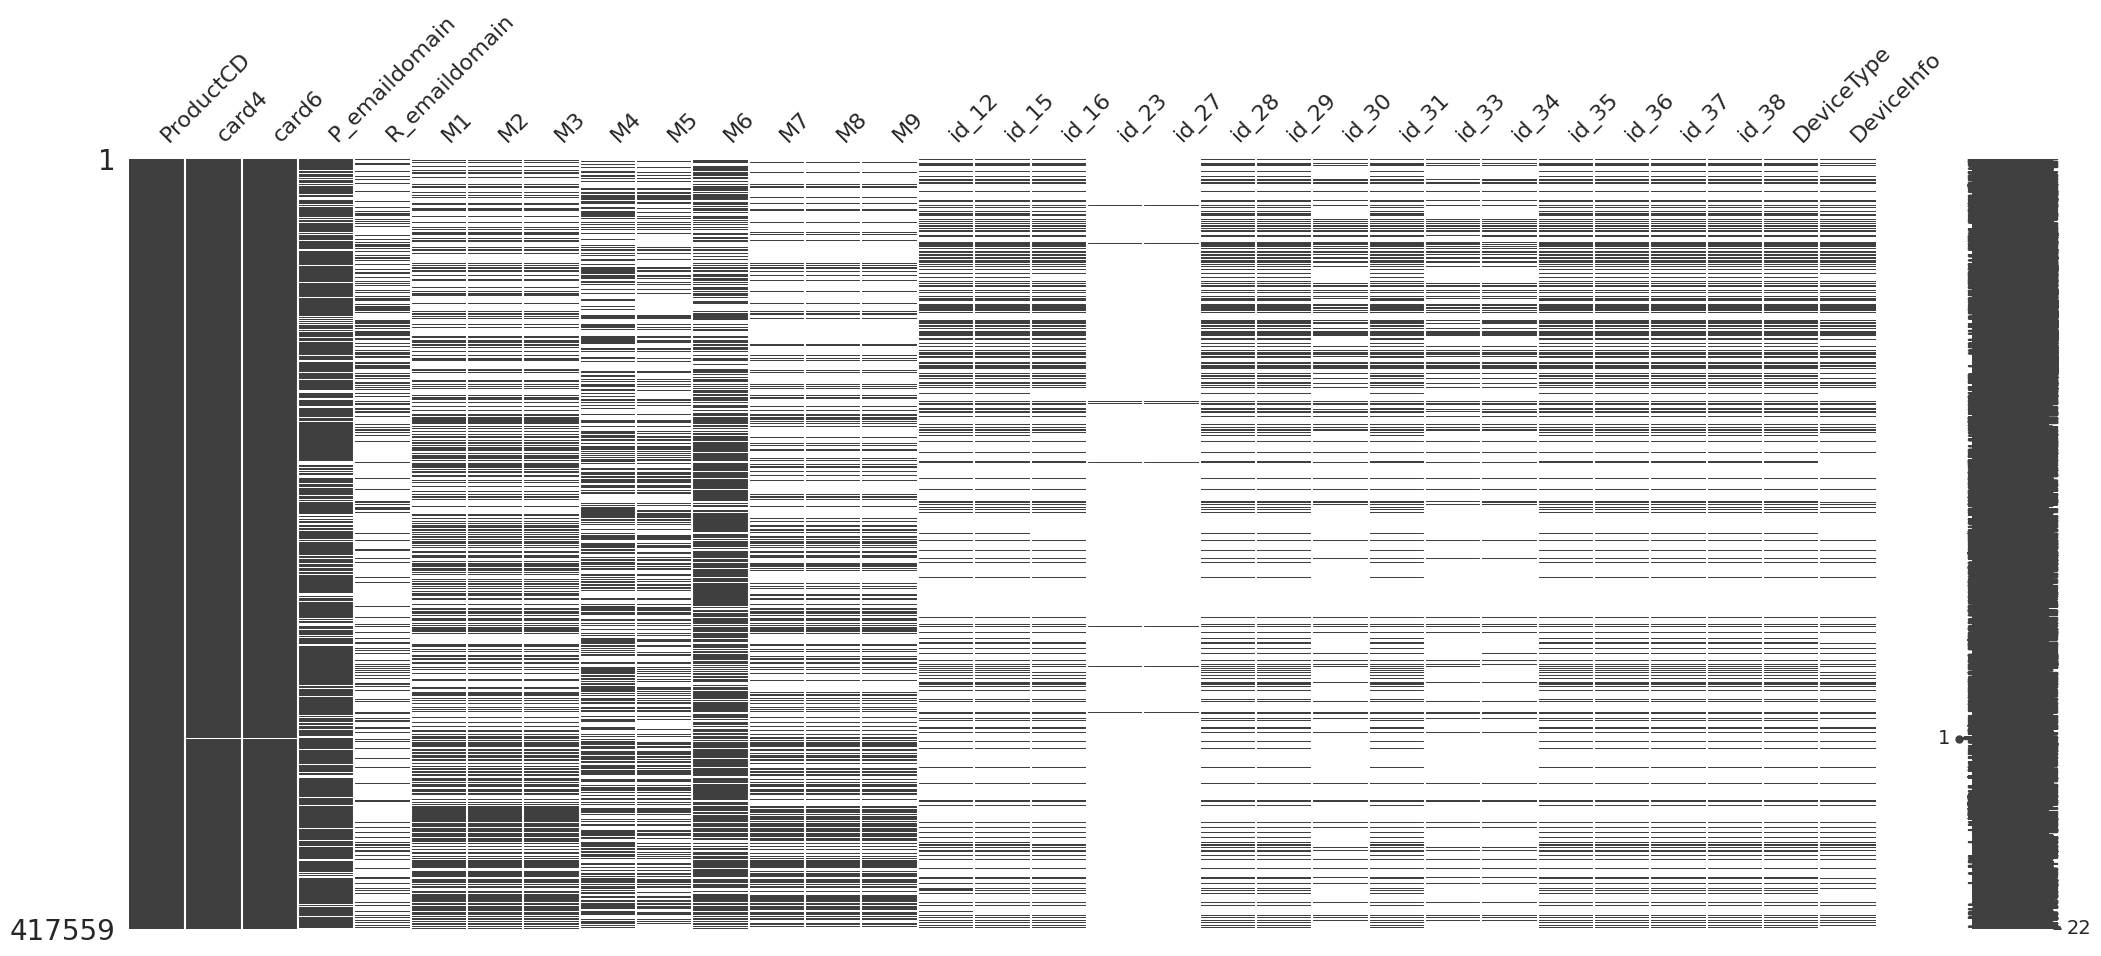

In [ ]:
msno.matrix(df_train.select_dtypes(include=['object']))
plt.show()

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:271: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


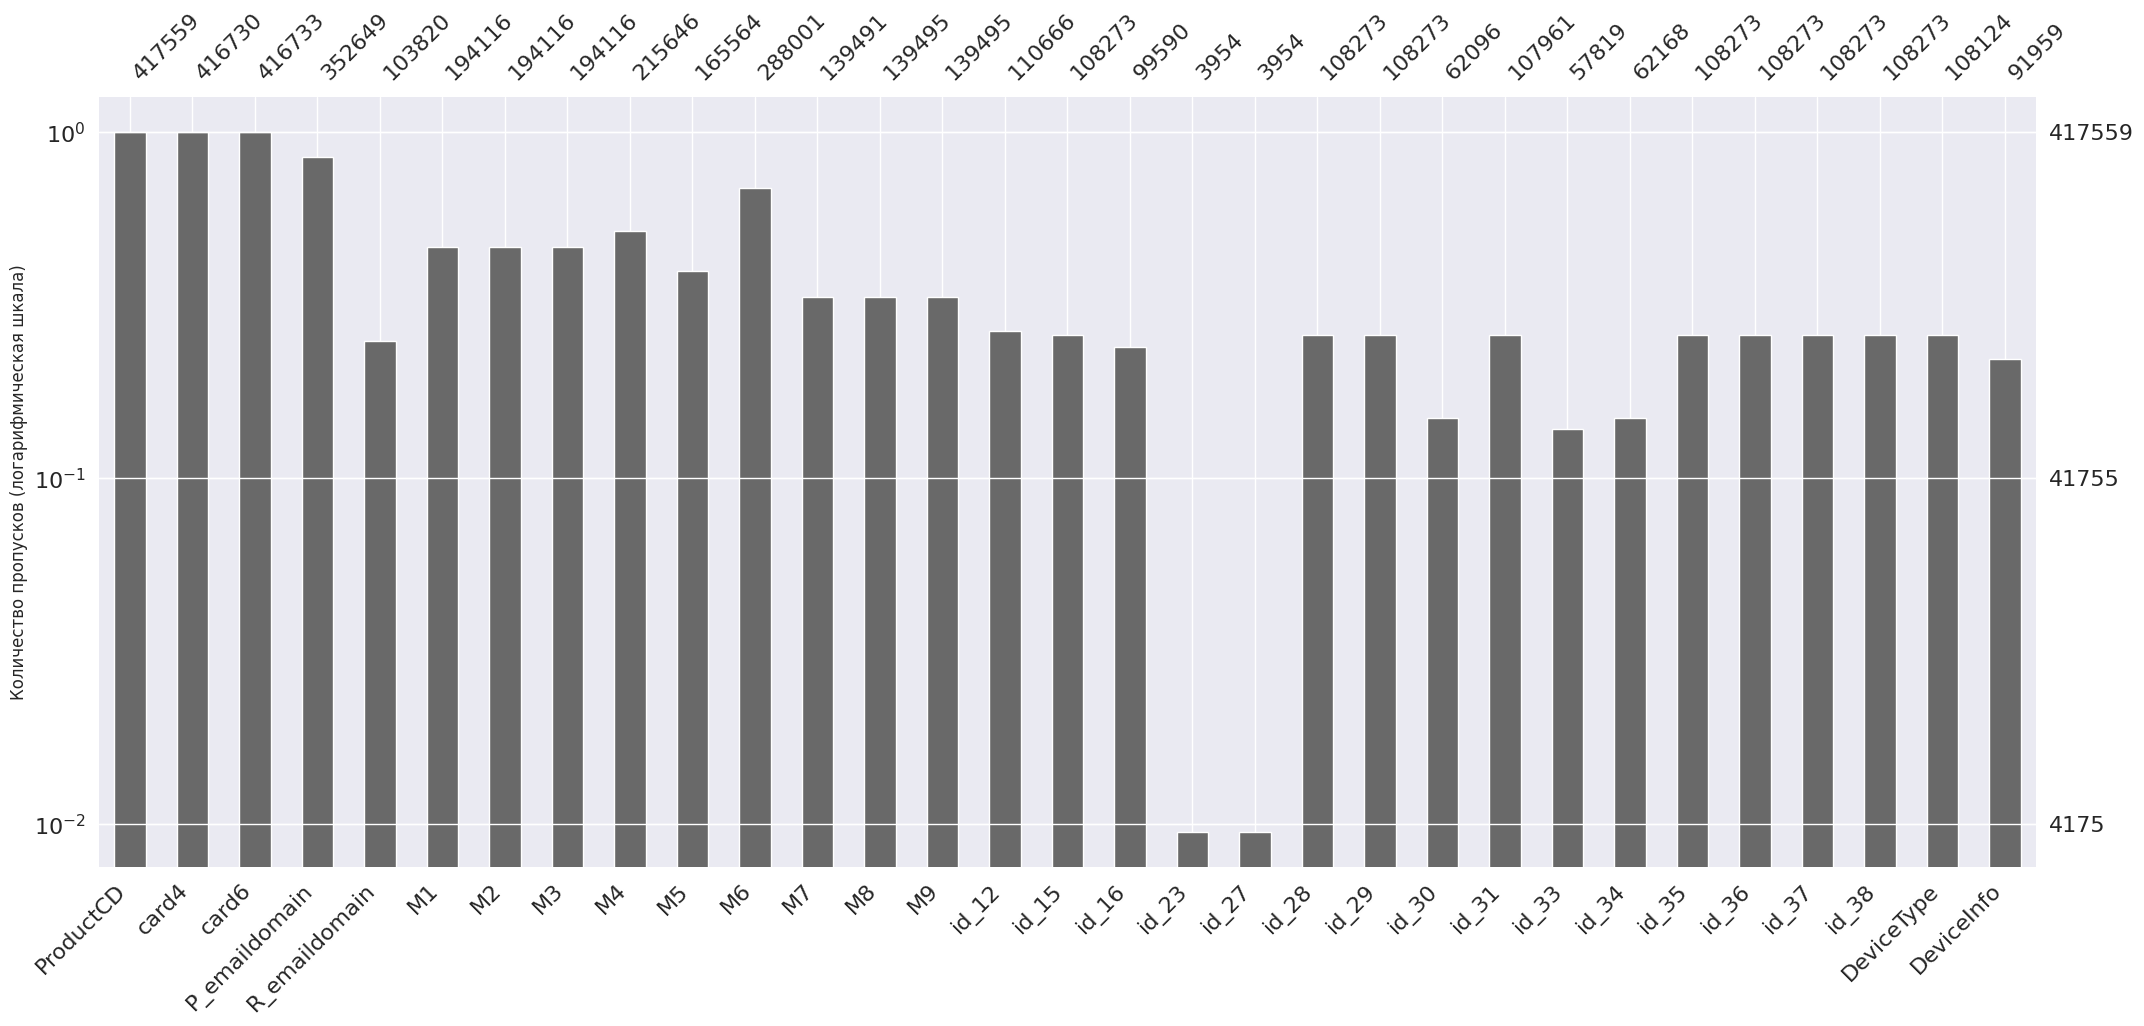

In [ ]:
ax = msno.bar(df_train.select_dtypes(include=['object']), log=True)
ax.set_ylabel("Количество пропусков (логарифмическая шкала)")
plt.show()

Пропусков очень много, особенно в столбцах `id_23` и `id_27`.

In [ ]:
sum(df_test.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).isna().sum())

0

In [ ]:
sum(df_test.select_dtypes(include=['object']).isna().sum())

3243583

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:271: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


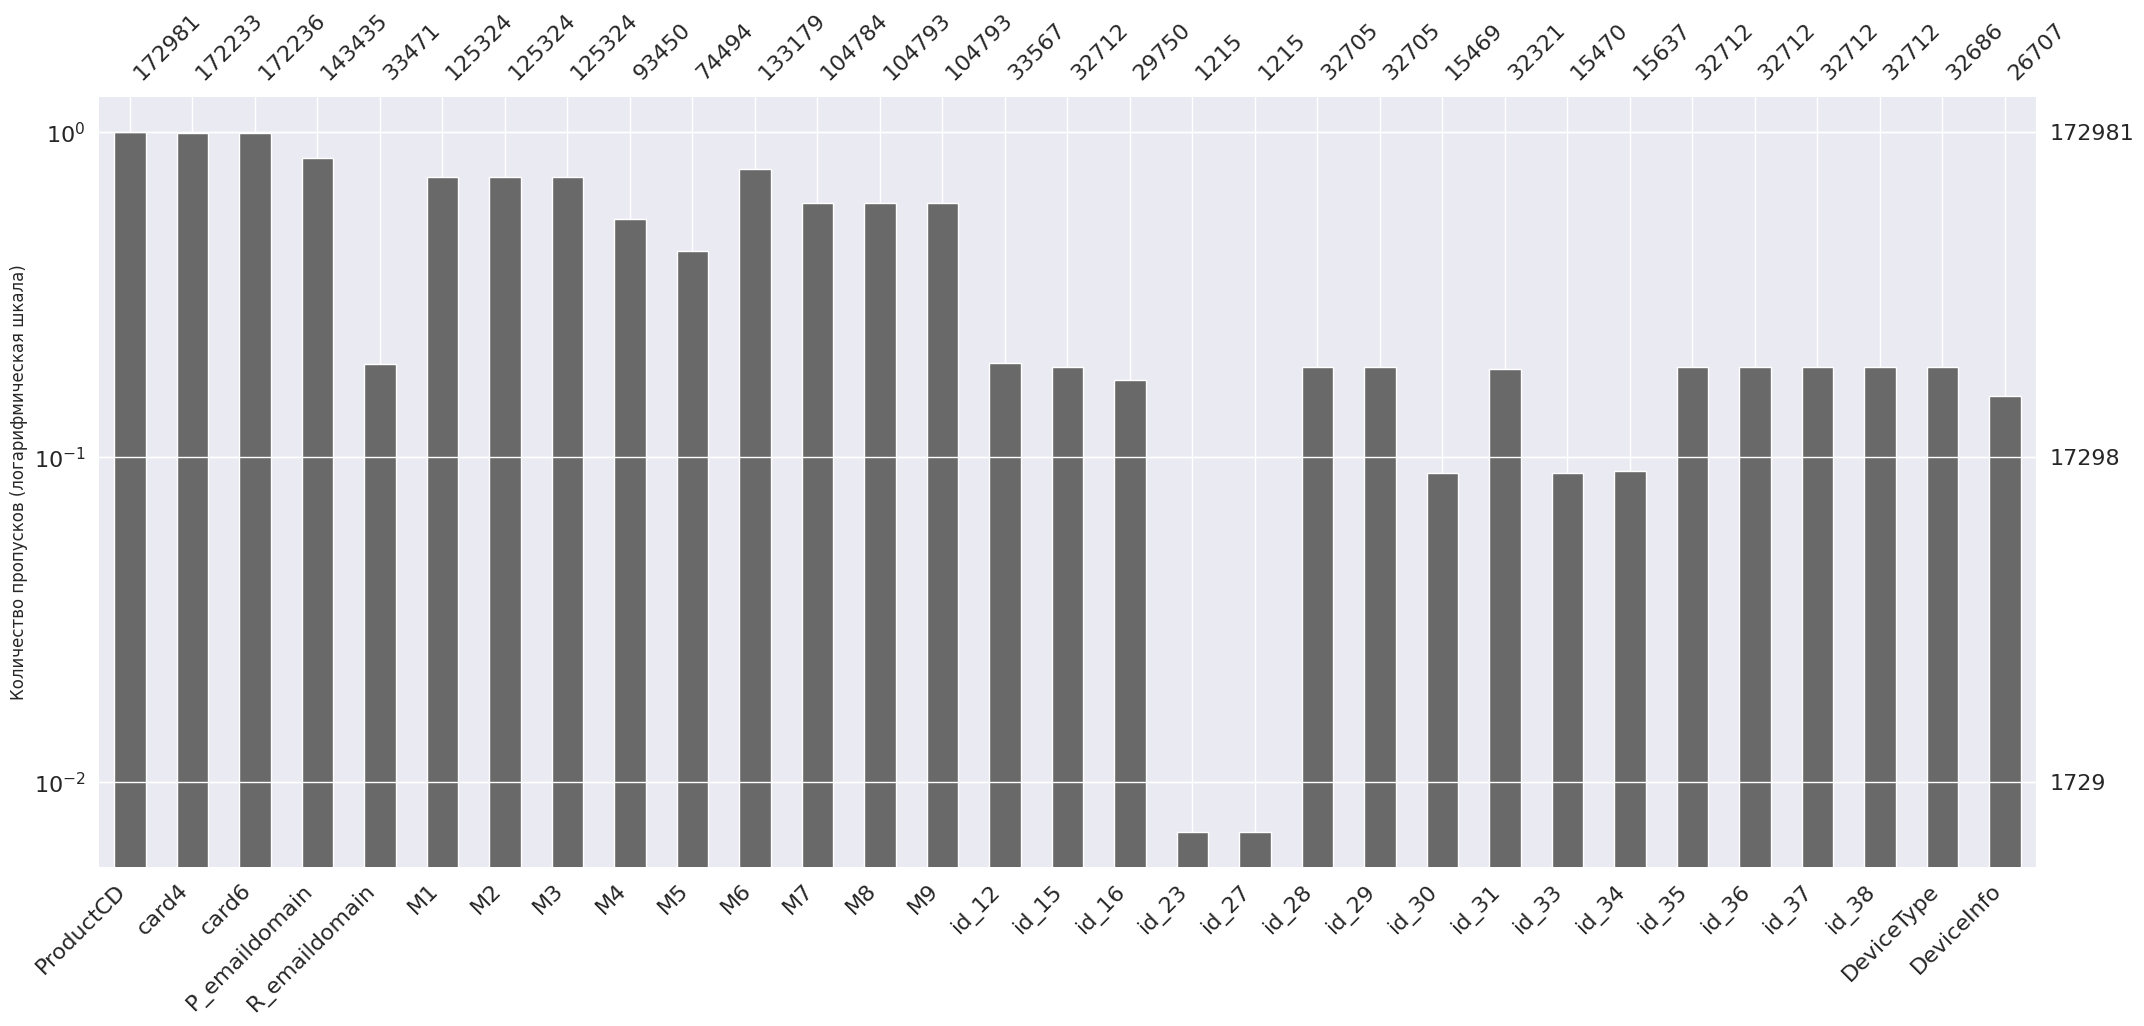

In [ ]:
ax = msno.bar(df_test.select_dtypes(include=['object']), log=True)
ax.set_ylabel("Количество пропусков (логарифмическая шкала)")
plt.show()

Далее заполним пропуски `card4`, `card6`, `P_emaildomain`, `M1-M9` модой.

In [ ]:
mode_cols = ['card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in df_train[mode_cols].columns:
    mode_value = df_train[col].mode()[0]
    df_train[col] = df_train[col].fillna(mode_value)
    df_test[col] = df_test[col].fillna(mode_value)

In [ ]:
for col in df_train.select_dtypes(object):
    print(f'{col}: {df_train[col].nunique()} уникальных значений')

ProductCD: 5 уникальных значений
card4: 4 уникальных значений
card6: 4 уникальных значений
P_emaildomain: 59 уникальных значений
R_emaildomain: 60 уникальных значений
M1: 2 уникальных значений
M2: 2 уникальных значений
M3: 2 уникальных значений
M4: 3 уникальных значений
M5: 2 уникальных значений
M6: 2 уникальных значений
M7: 2 уникальных значений
M8: 2 уникальных значений
M9: 2 уникальных значений
id_12: 2 уникальных значений
id_15: 3 уникальных значений
id_16: 2 уникальных значений
id_23: 3 уникальных значений
id_27: 2 уникальных значений
id_28: 2 уникальных значений
id_29: 2 уникальных значений
id_30: 71 уникальных значений
id_31: 110 уникальных значений
id_33: 183 уникальных значений
id_34: 4 уникальных значений
id_35: 2 уникальных значений
id_36: 2 уникальных значений
id_37: 2 уникальных значений
id_38: 2 уникальных значений
DeviceType: 2 уникальных значений
DeviceInfo: 1551 уникальных значений


In [ ]:
for col in df_test.select_dtypes(object):
    print(f'{col}: {df_test[col].nunique()} уникальных значений')

ProductCD: 5 уникальных значений
card4: 4 уникальных значений
card6: 2 уникальных значений
P_emaildomain: 59 уникальных значений
R_emaildomain: 58 уникальных значений
M1: 2 уникальных значений
M2: 2 уникальных значений
M3: 2 уникальных значений
M4: 3 уникальных значений
M5: 2 уникальных значений
M6: 2 уникальных значений
M7: 2 уникальных значений
M8: 2 уникальных значений
M9: 2 уникальных значений
id_12: 2 уникальных значений
id_15: 3 уникальных значений
id_16: 2 уникальных значений
id_23: 3 уникальных значений
id_27: 2 уникальных значений
id_28: 2 уникальных значений
id_29: 2 уникальных значений
id_30: 72 уникальных значений
id_31: 106 уникальных значений
id_33: 185 уникальных значений
id_34: 3 уникальных значений
id_35: 2 уникальных значений
id_36: 2 уникальных значений
id_37: 2 уникальных значений
id_38: 2 уникальных значений
DeviceType: 2 уникальных значений
DeviceInfo: 1033 уникальных значений


Много признаков с маленьким количеством уникальных значений. Возможно, что стоит их закодировать 0/1 или, в случае если больше 2 уникальных значений, закодировать при помощи `OrdinalEncoder`. При этом пропуски в бинарных столбцах будем кодировать 0, а в случае других признаков сначала заполним пропуски значением `unknown`, и лишь затем закодируем при помощи `OrdinalEncoder`.

**Выводы по пропускам:**
- распределение пропусков примерно одинаковое, что в тесте, что в трейне
- много пропусков, особенно в категориальных переменных
- возможно, следует удалить столбцы с больщим количеством пропусков (>95% пропусков в столбце)
- следует также подумать над стратегией заполнения пропусков

## Корреляции признаков

In [ ]:
num_correlations = df_train.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)[:10]
num_correlations

isFraud    1.000000
V257       0.270317
V246       0.251892
V233       0.242233
V201       0.234609
V244       0.234577
V232       0.230089
V242       0.229355
V231       0.227987
V217       0.225890
Name: isFraud, dtype: float64

interval columns not set, guessing: ['isFraud']


/home/jupyter/.local/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable DeviceInfo is large: 1551. Are you sure this is not an interval variable? Analysis for pairs of variables including DeviceInfo can be slow.
  warnings.warn(


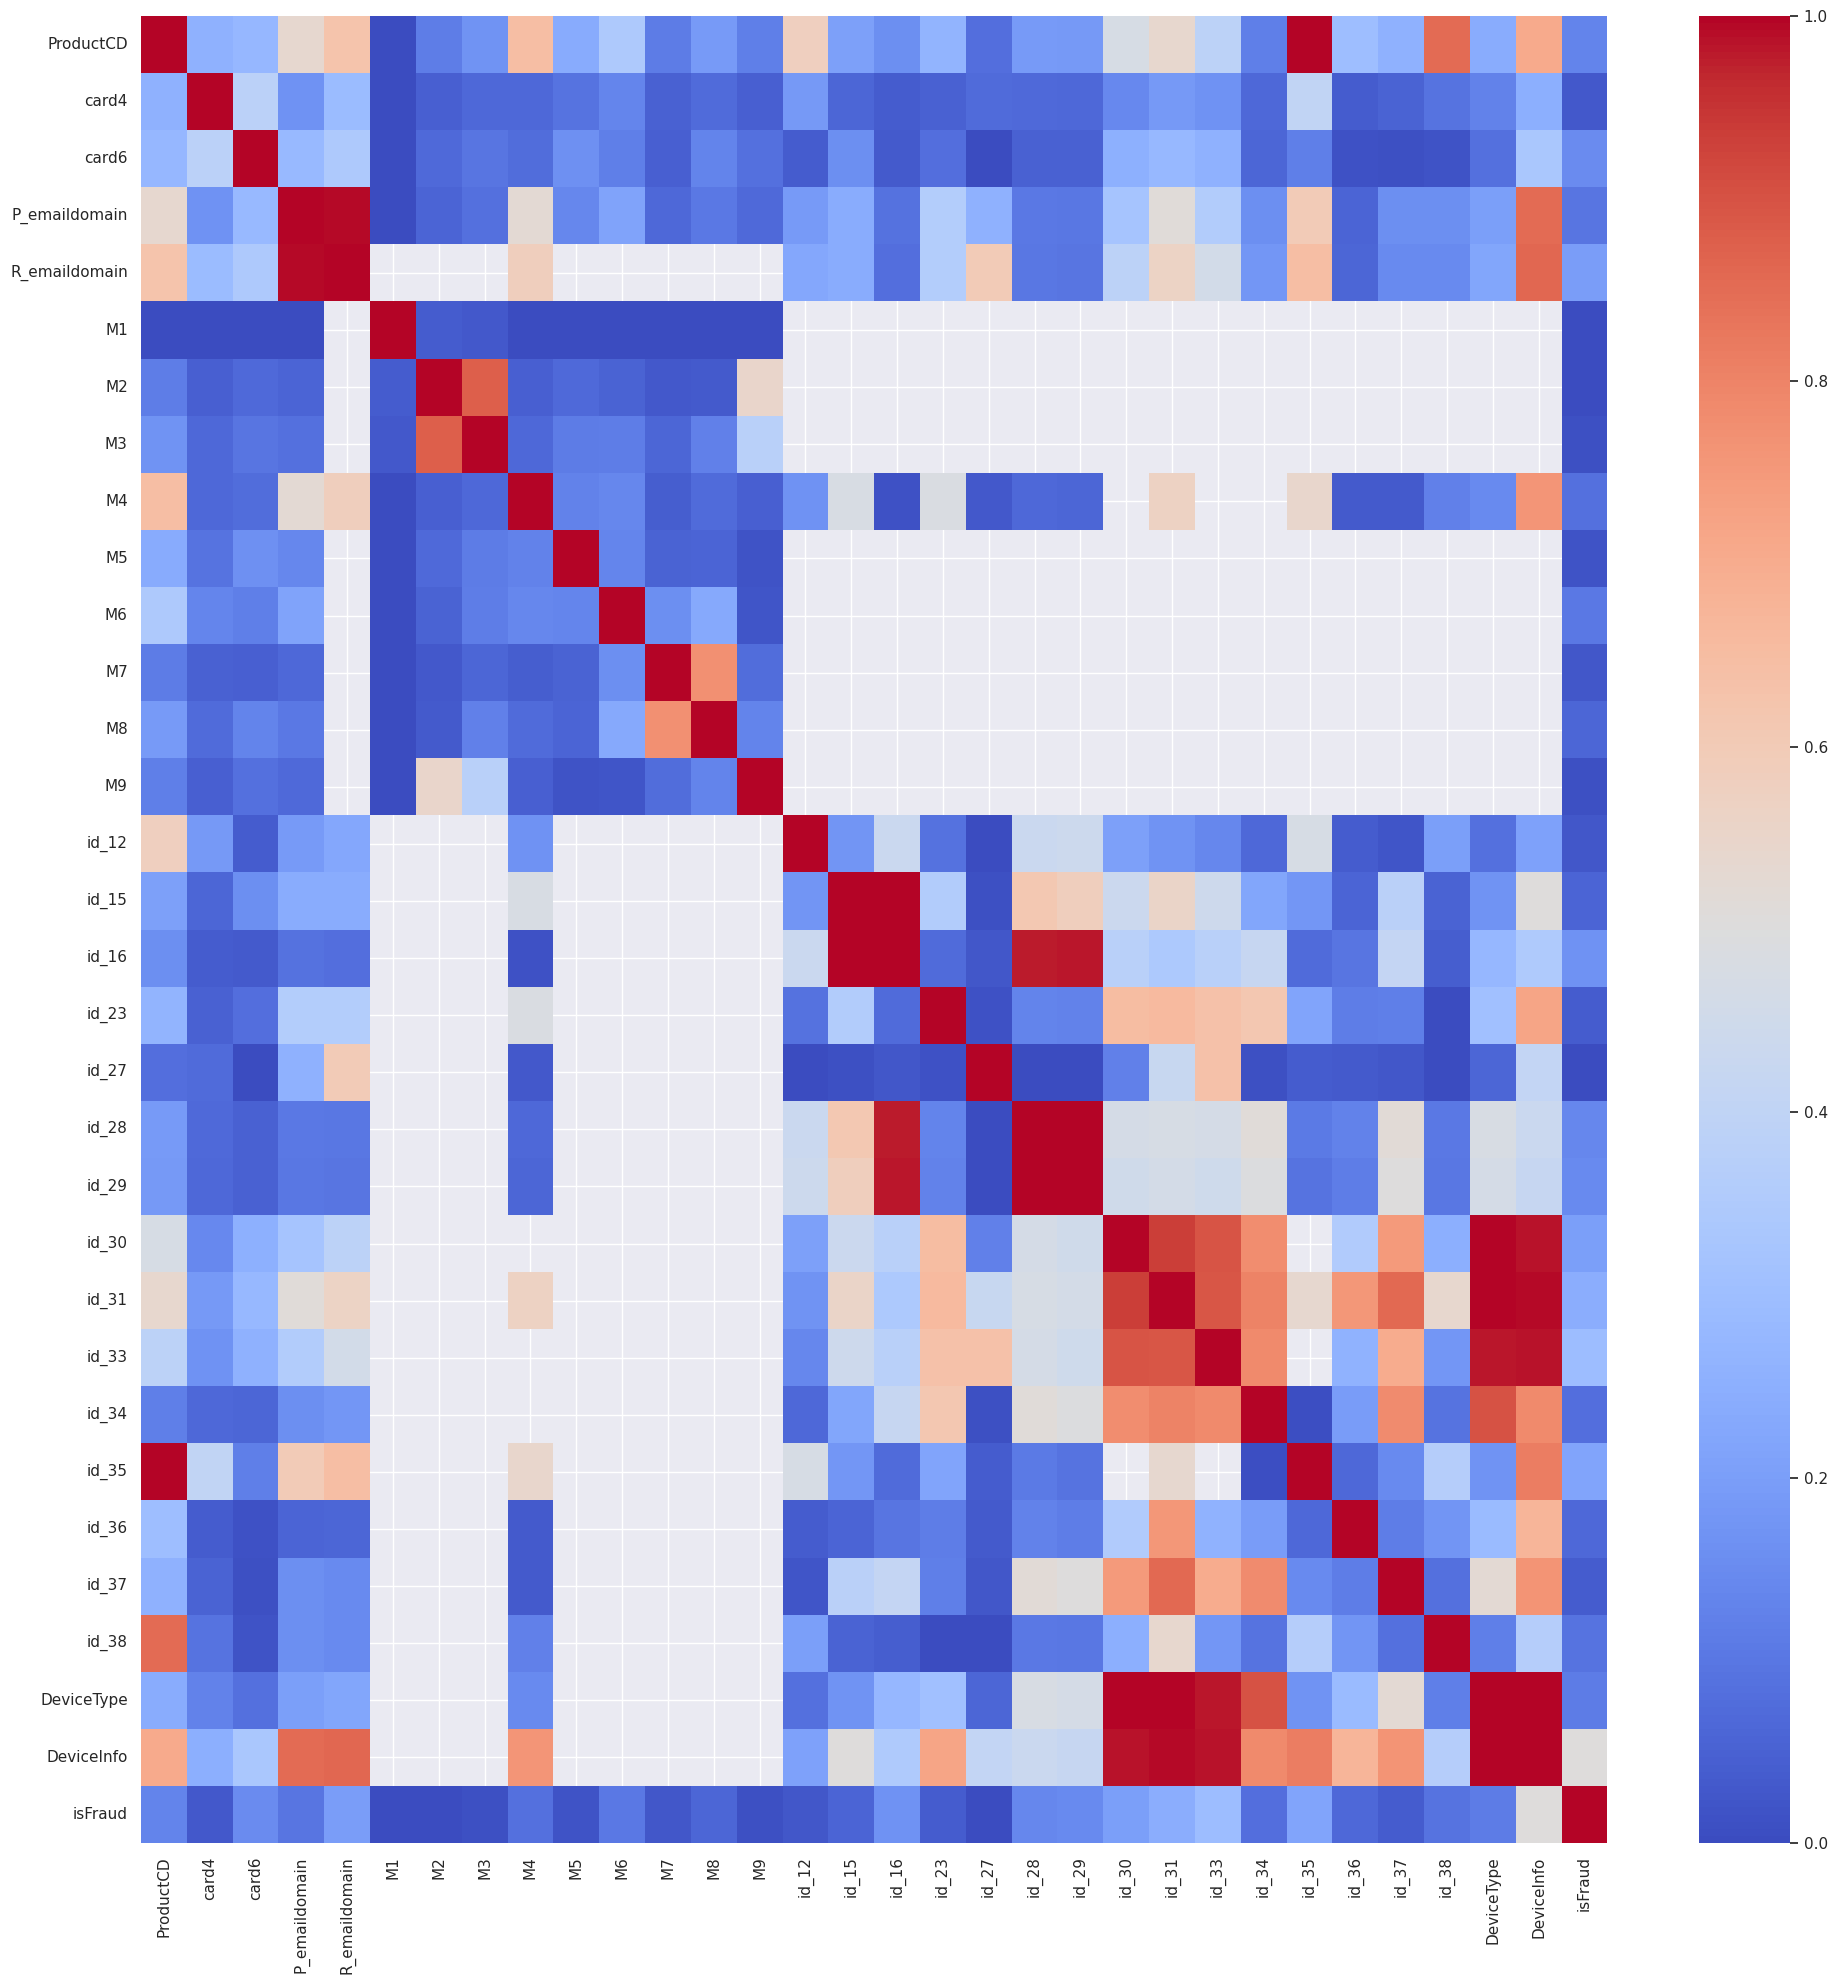

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_train.select_dtypes(include=['object', 'category']).join(df_train['isFraud']).phik_matrix(), cmap='coolwarm', ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
cat_correlations = df_train.select_dtypes(include=['object', 'category']).join(df_train['isFraud']).phik_matrix()['isFraud'].sort_values(ascending=False)[:10]
cat_correlations

interval columns not set, guessing: ['isFraud']


/home/jupyter/.local/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable DeviceInfo is large: 1551. Are you sure this is not an interval variable? Analysis for pairs of variables including DeviceInfo can be slow.
  warnings.warn(


isFraud          1.000000
DeviceInfo       0.504424
id_33            0.294664
id_31            0.245692
id_35            0.217604
id_30            0.200570
R_emaildomain    0.195448
id_16            0.165762
card6            0.151131
id_29            0.146057
Name: isFraud, dtype: float64

**Вывод по корреляциям:**
- не наблюдается сильных корреляций переменных с целевой переменной
- поэтому исходя из этого удалять переменные не будем

## Анализ целевой переменной

Наблюдается сильный дисбаланс классов в целевой переменной.

Target value counts:  0    402838
1     14721
Name: isFraud, dtype: int64


<Axes: >

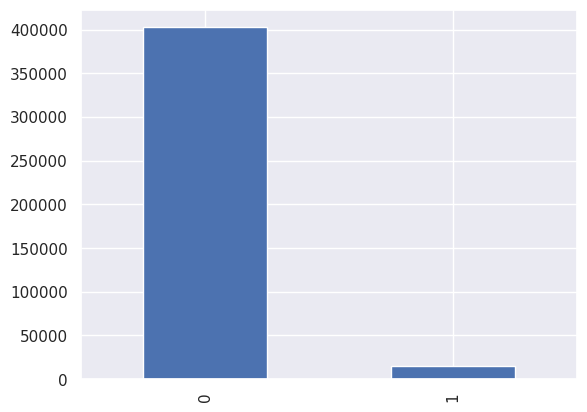

In [ ]:
print("Target value counts: ", df_train['isFraud'].value_counts())
df_train['isFraud'].value_counts().plot(kind='bar')

In [ ]:
percent_fraud = round(df_train[df_train['isFraud'] == 1].shape[0]/df_train[df_train['isFraud'] == 0].shape[0]*100, 3)
print(f'Доля фрода в данных: {percent_fraud}%')

Доля фрода в данных: 3.654%


## Удаление дубликатов

In [ ]:
df_train.duplicated().sum()

293

In [ ]:
df_train.drop_duplicates(inplace=True)

## Понижение размерности

In [ ]:
NUM_COLS = df_train.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).columns

### Попарная взаимосвязь признаков

Так как данных много, то удалим признаки с сильной корреляцией(>95%). В случае, если бы не признаков было меньше, стоило бы более пристально отнестись к удалению признаков.

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
corr_features = correlation(df_train[NUM_COLS], 0.95)

In [ ]:
df_train_corr = df_train.drop(corr_features, axis=1)
df_test_corr = df_test.drop(corr_features, axis=1)
dropped_features1 = df_train_corr.shape[1]
print(f'После удаления {len(corr_features)} признаков, осталось {dropped_features1} признаков.')

После удаления 146 признаков, осталось 286 признаков.


### Корреляция с целевой переменной

In [ ]:
def corrwith_target(dataframe, target, threshold):
    cor = dataframe.corr(numeric_only=True)
    #Correlation with output variable
    cor_target = abs(cor[target])
    #Selecting non correlated features
    relevant_features = cor_target[cor_target<threshold]
    return relevant_features.index.tolist()[:-1]


corrwith_cols = corrwith_target(df_train_corr.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']), 'isFraud', 0.01)

In [ ]:
df_train_corw = df_train_corr.drop(corrwith_cols, axis=1)
df_test_corw = df_test_corr.drop(corrwith_cols, axis=1)
dropped_features2 = df_train_corw.shape[1]
print(f'После удаления {len(corrwith_cols)} признаков, осталось {dropped_features2} признаков.')

После удаления 30 признаков, осталось 256 признаков.


### Процент пропусков

Посмотрим признаки, в которых процент пропущенных значений больще 95%. Пропуски после применении функции `reduce_mem_usage` есть только в категориальных столбцах. Посмотрим сколько может удалиться столбцов, если поставим порог 95%.

In [ ]:
def percentna(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isna().sum()/dataframe.shape[1])>threshold]
    return columns.tolist()

na_columns = percentna(df_train_corw.drop(['isFraud'], axis=1), 0.95)
len(na_columns), df_train_corw.select_dtypes(object).shape[1]

(18, 31)

Как мы видим, в таком случае мы удалим почти все столбцы, что плохо. Так как мы выяснили ранее, что категориальные столбцы относительно сильно коррелируют с целевой переменной, то будем кодировать их по стратегии, которую описали выше.

In [ ]:
for col in df_train_corw.select_dtypes(object):
    if df_train_corw[col].nunique() <= 2:
        data_unique = df_train_corw[col].unique()
        data_unique_filtered = list(filter(lambda x: x is not None and not (isinstance(x, float) and math.isnan(x)), data_unique))
        df_train_corw[col] = df_train_corw[col].apply(lambda x: 0 if x == data_unique_filtered[0] else 0)

        df_test_corw[col] = df_test_corw[col].apply(lambda x: 0 if x == data_unique_filtered[0] else 0)

In [ ]:
for col in df_train_corw.select_dtypes(object):

    df_train_corw[col] = df_train_corw[col].fillna('unknown')
    df_test_corw[col] = df_test_corw[col].fillna('unknown')


print('Missing data in train: {:.5f}%'.format(df_train_corw.isnull().sum().sum() / (df_train_corw.shape[0] * df_train_corw.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test_corw.isnull().sum().sum() / (df_test_corw.shape[0] * df_test_corw.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [ ]:
sum(df_test_corw.isna().sum())

0

In [ ]:
df_train_corw['isFraud'].value_counts()

0    402545
1     14721
Name: isFraud, dtype: int64

## Кодировка категориальных признаков

Создадим пайплайн, который будет кодировать оставшиеся категориальные переменные для таких алгоритмов машинного обучения, как XGBoost и LightGBM. Для CatBoost оставим категориальные столбцы без кодировки.

In [ ]:
CAT_COLS = df_train_corw.select_dtypes(object).columns.tolist()

In [ ]:
encoder_pipeline = Pipeline(steps=[
    ('label_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', encoder_pipeline, CAT_COLS)
], remainder='passthrough'
).set_output(transform='pandas')

df_train_new = preprocessor.fit_transform(df_train_corw.drop(['isFraud'], axis=1))
df_test_new = preprocessor.transform(df_test_corw)

In [ ]:
df_train_new['isFraud'] = df_train_corw['isFraud'].copy()
df_train_new.shape, df_train_corw.shape

((417266, 256), (417266, 256))

In [ ]:
sum(df_train_new.isna().sum())

0

In [ ]:
df_train_new['isFraud'].value_counts()

0    402545
1     14721
Name: isFraud, dtype: int64

In [ ]:
print(df_train_new.select_dtypes(object).columns.tolist())
print(df_train_corw.select_dtypes(object).columns.tolist())

[]
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4', 'id_15', 'id_23', 'id_30', 'id_31', 'id_33', 'id_34', 'DeviceInfo']


In [ ]:
NUM_COLS = df_train_corw.drop(['isFraud'], axis=1).select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).columns.tolist()

In [ ]:
len(NUM_COLS), len(df_train_corw.select_dtypes(include=['uint16', 'float', 'float32', 'uint8']).columns)

(224, 225)

In [ ]:
df_train_cat = df_train_corw.copy()
df_test_cat = df_test_corw.copy()

In [ ]:
df_train_cat.shape, df_train_corw.shape

((417266, 256), (417266, 256))

In [ ]:
# from google.colab import files

# df_train_cat.to_csv('df_train_cat.csv', index=True)
# # Скачивание файла
# files.download('df_train_cat.csv')

In [ ]:
all_features = df_train_new.drop(['isFraud'], axis=1).columns.tolist()

pipeline = Pipeline(steps=[
    ('scaler', ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), all_features)
        ],
        remainder='passthrough'
    ))
])


scaled_data_train = pipeline.fit_transform(df_train_new.drop(['isFraud'], axis=1))
scaled_data_test = pipeline.transform(df_test_new)

df_train_num = pd.DataFrame(scaled_data_train, columns=all_features)
df_test_num = pd.DataFrame(scaled_data_test, columns=all_features)

In [ ]:
df_train_num['isFraud'] = df_train_new['isFraud'].set_axis(df_train_num.index)
df_train_num.head()

,cat__ProductCD,cat__card4,cat__card6,cat__P_emaildomain,cat__R_emaildomain,cat__M4,cat__id_15,cat__id_23,cat__id_30,cat__id_31,cat__id_33,cat__id_34,cat__DeviceInfo,remainder__card1,remainder__card3,remainder__card5,remainder__addr1,remainder__addr2,remainder__dist2,remainder__C1,remainder__C5,remainder__C9,remainder__D1,remainder__D3,remainder__D4,remainder__D5,remainder__D6,remainder__D9,remainder__D10,remainder__D11,remainder__D12,remainder__D14,remainder__D15,remainder__M1,remainder__M2,remainder__M3,remainder__M5,remainder__M6,remainder__M7,remainder__M8,...,remainder__V315,remainder__V316,remainder__V318,remainder__V320,remainder__V322,remainder__V323,remainder__V324,remainder__V326,remainder__V327,remainder__V328,remainder__V329,remainder__V332,remainder__V338,remainder__id_02,remainder__id_03,remainder__id_07,remainder__id_08,remainder__id_12,remainder__id_13,remainder__id_14,remainder__id_16,remainder__id_17,remainder__id_18,remainder__id_19,remainder__id_20,remainder__id_21,remainder__id_22,remainder__id_24,remainder__id_25,remainder__id_26,remainder__id_27,remainder__id_28,remainder__id_29,remainder__id_32,remainder__id_35,remainder__id_36,remainder__id_37,remainder__id_38,remainder__DeviceType,isFraud
0,1.00,0.333333,0.333333,0.275862,0.816667,1.0,1.000000,1.0,1.000000,0.990909,1.000000,1.00,0.994842,0.743044,0.386364,0.311594,0.489796,0.83871,0.0,0.000213,0.0,0.004762,0.023401,0.020290,0.000000,0.000000,0.0,0.0,0.017157,0.100752,0.0,0.0,0.093437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000208,0.000016,0.000016,0.00001,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.00,0.666667,0.333333,0.275862,0.816667,0.0,1.000000,1.0,1.000000,0.990909,1.000000,1.00,0.994842,0.100885,0.386364,0.021739,0.512472,0.83871,0.0,0.000213,0.0,0.000000,0.001560,0.000000,0.131551,0.000000,0.0,0.0,0.001225,0.000000,0.0,0.0,0.093437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000208,0.000016,0.000016,0.00001,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.00,1.000000,0.666667,0.603448,0.816667,0.0,1.000000,1.0,1.000000,0.990909,1.000000,1.00,0.994842,0.210566,0.386364,0.485507,0.523810,0.83871,0.0,0.000213,0.0,0.004762,0.001560,0.000000,0.131551,0.000000,0.0,0.0,0.001225,0.554887,0.0,0.0,0.443826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000208,0.000016,0.000016,0.00001,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.00,0.666667,0.666667,0.913793,0.816667,0.0,1.000000,1.0,1.000000,0.990909,1.000000,1.00,0.994842,0.984824,0.386364,0.130435,0.854875,0.83871,0.0,0.000427,0.0,0.004762,0.176287,0.001449,0.232086,0.001289,0.0,0.0,0.104167,0.000000,0.0,0.0,0.216908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000208,0.000798,0.012383,0.00001,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.25,0.666667,0.333333,0.275862,0.816667,0.0,0.333333,1.0,0.098592,0.936364,0.622951,0.75,0.530625,0.201023,0.386364,0.021739,0.727891,0.83871,0.0,0.000213,0.0,0.000000,0.001560,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000208,0.000016,0.000016,0.00001,0.030303,0.02,0.029412,0.022222,0.052632,0.0625,0.04,0.000018,0.00004,0.070789,0.0,0.0,0.0,0.0,0.0,0.131064,0.0,0.515385,0.0,0.774476,0.080071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df_train_num.shape, df_test_num.shape

((417266, 256), (172981, 255))

**Выводы по EDA**:
- при помощи функции `reduce_mem_usage` были оптимизированы типы исходных данных для снижения уровня потребления памяти датасетами.
- процент пропусков в данных: ~4%.
- у категориальных столбцов разное количество уникальных значений (от 2 до 1551).
- признаки с двумя категориями закодированы 0 и 1, остальные закодированы при помощи `OrdinalEncoder`. Пропуски в столбцах `card4`, `card6`, `P_emaildomain`, `M1-M9` были заполнены модой в виду того, что в них небольшой процент пропусков. В остальных столбцах пропуски перед кодированием были заполнены 0 в случае бинарных столбцов, а в случае других признаков пропуски заполнены значением `unknown`.
- сильных корреляций с целевой переменной не наблюдается.
- сильный дисбаланс классов.
- были удалены дубликаты (293).
- были удалены признаки с сильной попарной корреляцией(>99%).
- также были удалены признаки со слабой корреляцией с целевой переменной.
- были подготовлены датасеты с категориальными (для CatBoost) и полностью числовыми признаками (для XGBoost и LightGBM). Числовые столбцы были отмастшабированы при помощи `MinMaxScaler`.


# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

### CatBoost

In [ ]:
%%time
def objective(trial, X_train, y_train):

    iterations = trial.suggest_int('iterations',150, 300)
    depth = trial.suggest_int('depth', 1, 5)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 30, 100)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 5, 15)

    model = Pipeline([
        ('classifier', CatBoostClassifier(
                                    cat_features=CAT_COLS,
                                    iterations=iterations,
                                    depth=depth,
                                    learning_rate=learning_rate,
                                    min_data_in_leaf=min_data_in_leaf,
                                    l2_leaf_reg=l2_leaf_reg,
                                    random_state=42, verbose=False,
                                    # task_type='GPU'
        ))
    ])

    score = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc', verbose = 3).mean()

    return score


study_catboost = optuna.create_study(sampler=sampler, directions=['maximize'])
study_catboost.optimize(lambda trial: objective(trial, df_train_cat.drop(['isFraud'], axis=1), df_train_cat['isFraud']), n_trials=10)

[I 2025-03-20 16:36:56,141] A new study created in memory with name: no-name-9c90bd3f-28ae-4c8d-b00e-569560cc4813


[CV] END ................................ score: (test=0.857) total time= 1.0min
[CV] END ................................ score: (test=0.860) total time= 1.0min


[I 2025-03-20 16:40:00,476] Trial 0 finished with value: 0.8596185253801697 and parameters: {'iterations': 206, 'depth': 5, 'learning_rate': 0.17524101118128144, 'min_data_in_leaf': 72, 'l2_leaf_reg': 6.560186404424365}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.862) total time= 1.0min
[CV] END ................................ score: (test=0.815) total time=  16.6s
[CV] END ................................ score: (test=0.848) total time=  16.4s
[CV] END ................................ score: (test=0.846) total time=  16.4s


[I 2025-03-20 16:40:50,164] Trial 1 finished with value: 0.836370389905961 and parameters: {'iterations': 173, 'depth': 1, 'learning_rate': 0.29621516588303487, 'min_data_in_leaf': 72, 'l2_leaf_reg': 12.080725777960454}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.846) total time=  25.4s
[CV] END ................................ score: (test=0.861) total time=  25.5s


[I 2025-03-20 16:42:07,189] Trial 2 finished with value: 0.8556005516021102 and parameters: {'iterations': 153, 'depth': 5, 'learning_rate': 0.2595942550311264, 'min_data_in_leaf': 45, 'l2_leaf_reg': 6.818249672071007}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.860) total time=  25.9s
[CV] END ................................ score: (test=0.809) total time=  19.5s
[CV] END ................................ score: (test=0.850) total time=  19.3s


[I 2025-03-20 16:43:07,086] Trial 3 finished with value: 0.8339984310796765 and parameters: {'iterations': 177, 'depth': 2, 'learning_rate': 0.0779014312627624, 'min_data_in_leaf': 60, 'l2_leaf_reg': 7.912291401980419}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.843) total time=  20.7s
[CV] END ................................ score: (test=0.781) total time=  21.9s
[CV] END ................................ score: (test=0.834) total time=  21.7s


[I 2025-03-20 16:44:12,867] Trial 4 finished with value: 0.8102727156556221 and parameters: {'iterations': 242, 'depth': 1, 'learning_rate': 0.03135775732257745, 'min_data_in_leaf': 56, 'l2_leaf_reg': 9.56069984217036}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.816) total time=  21.9s
[CV] END ................................ score: (test=0.799) total time=  24.3s
[CV] END ................................ score: (test=0.842) total time=  24.0s
[CV] END ................................ score: (test=0.832) total time=  24.1s


[I 2025-03-20 16:45:25,513] Trial 5 finished with value: 0.8240602477498817 and parameters: {'iterations': 268, 'depth': 1, 'learning_rate': 0.07475992999956503, 'min_data_in_leaf': 72, 'l2_leaf_reg': 5.4645041271999775}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.712) total time=  21.8s
[CV] END ................................ score: (test=0.761) total time=  21.8s


[I 2025-03-20 16:46:31,091] Trial 6 finished with value: 0.7404510998924678 and parameters: {'iterations': 241, 'depth': 1, 'learning_rate': 0.012897950480855536, 'min_data_in_leaf': 97, 'l2_leaf_reg': 14.656320330745594}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.749) total time=  21.7s
[CV] END ................................ score: (test=0.793) total time=  34.4s
[CV] END ................................ score: (test=0.840) total time=  34.6s


[I 2025-03-20 16:48:14,672] Trial 7 finished with value: 0.8159927073452898 and parameters: {'iterations': 272, 'depth': 2, 'learning_rate': 0.01465352103067214, 'min_data_in_leaf': 78, 'l2_leaf_reg': 9.401524937396013}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.815) total time=  34.4s
[CV] END ................................ score: (test=0.773) total time=  21.7s
[CV] END ................................ score: (test=0.829) total time=  21.6s


[I 2025-03-20 16:49:19,755] Trial 8 finished with value: 0.8038899281750144 and parameters: {'iterations': 168, 'depth': 3, 'learning_rate': 0.011439974749291277, 'min_data_in_leaf': 94, 'l2_leaf_reg': 7.587799816000169}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.810) total time=  21.5s
[CV] END ................................ score: (test=0.815) total time=  33.6s
[CV] END ................................ score: (test=0.853) total time=  33.4s


[I 2025-03-20 16:51:00,699] Trial 9 finished with value: 0.8387328168406908 and parameters: {'iterations': 250, 'depth': 2, 'learning_rate': 0.07648565112369948, 'min_data_in_leaf': 68, 'l2_leaf_reg': 6.848544555255271}. Best is trial 0 with value: 0.8596185253801697.


[CV] END ................................ score: (test=0.848) total time=  33.7s
CPU times: user 53min 28s, sys: 33.2 s, total: 54min 1s
Wall time: 14min 4s


In [ ]:
cb_best = CatBoostClassifier(**study_catboost.best_params, cat_features=CAT_COLS, random_state=RANDOM_STATE, verbose=False)
cb_best.fit(df_train_cat.drop(['isFraud'], axis=1), df_train_cat['isFraud'])

cb_pred = cb_best.predict_proba(df_train_cat.drop(['isFraud'], axis=1))[:, 1]
cb_score = roc_auc_score(df_train_cat['isFraud'], cb_pred)
print(f"CatBoost (best): {cb_score}")

CatBoost (best): 0.9023441064096003


### LightGBM

In [ ]:
%%time
def objective(trial, X_train, y_train):
    params_lgb = {
        'objective' : 'binary',
        # 'n_jobs' : -1,
        # 'device': 'gpu',  # Использование GPU
        'num_leaves' : trial.suggest_int('num_leaves', 10, 300),
        'max_depth' : trial.suggest_int('max_depth', 5, 25),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }

    # Обучение модели
    model = LGBMClassifier(**params_lgb)

    score = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc', verbose = 4).mean()

    return score

study_lgbm = optuna.create_study(sampler=sampler, directions=['maximize'])
study_lgbm.optimize(lambda trial: objective(trial, df_train_num.drop(['isFraud'], axis=1), df_train_num['isFraud']), n_trials=10)

[I 2025-03-20 16:53:01,840] A new study created in memory with name: no-name-76a2677a-ae2b-4a47-94f1-964a67043604


[CV] END ................................ score: (test=0.851) total time= 1.4min
[CV] END ................................ score: (test=0.867) total time= 1.6min


[I 2025-03-20 16:57:33,176] Trial 0 finished with value: 0.8558681489694203 and parameters: {'num_leaves': 292, 'max_depth': 21, 'learning_rate': 0.3946212980759094, 'n_estimators': 906, 'min_child_samples': 60}. Best is trial 0 with value: 0.8558681489694203.


[CV] END ................................ score: (test=0.849) total time= 1.6min
[CV] END ................................ score: (test=0.822) total time=   8.2s
[CV] END ................................ score: (test=0.864) total time=   9.3s


[I 2025-03-20 16:58:00,262] Trial 1 finished with value: 0.849105686157932 and parameters: {'num_leaves': 278, 'max_depth': 6, 'learning_rate': 0.02152628097221528, 'n_estimators': 140, 'min_child_samples': 33}. Best is trial 0 with value: 0.8558681489694203.


[CV] END ................................ score: (test=0.862) total time=   9.2s
[CV] END ................................ score: (test=0.843) total time=  22.7s
[CV] END ................................ score: (test=0.863) total time=  26.3s


[I 2025-03-20 16:59:11,315] Trial 2 finished with value: 0.8115768237049572 and parameters: {'num_leaves': 123, 'max_depth': 10, 'learning_rate': 0.2558586885593425, 'n_estimators': 421, 'min_child_samples': 29}. Best is trial 0 with value: 0.8558681489694203.


[CV] END ................................ score: (test=0.729) total time=  21.6s
[CV] END ................................ score: (test=0.854) total time=   8.2s
[CV] END ................................ score: (test=0.888) total time=   9.5s


[I 2025-03-20 16:59:38,931] Trial 3 finished with value: 0.8664912756055543 and parameters: {'num_leaves': 167, 'max_depth': 7, 'learning_rate': 0.23062618121677933, 'n_estimators': 167, 'min_child_samples': 99}. Best is trial 3 with value: 0.8664912756055543.


[CV] END ................................ score: (test=0.858) total time=   9.6s
[CV] END ................................ score: (test=0.860) total time=  43.3s
[CV] END ................................ score: (test=0.891) total time=  50.2s


[I 2025-03-20 17:02:04,422] Trial 4 finished with value: 0.8772060453248193 and parameters: {'num_leaves': 234, 'max_depth': 9, 'learning_rate': 0.010218376758008088, 'n_estimators': 834, 'min_child_samples': 71}. Best is trial 4 with value: 0.8772060453248193.


[CV] END ................................ score: (test=0.881) total time=  51.6s
[CV] END ................................ score: (test=0.865) total time=  39.2s
[CV] END ................................ score: (test=0.910) total time=  45.1s


[I 2025-03-20 17:04:14,602] Trial 5 finished with value: 0.8885261616692457 and parameters: {'num_leaves': 222, 'max_depth': 21, 'learning_rate': 0.01335979032844557, 'n_estimators': 422, 'min_child_samples': 12}. Best is trial 5 with value: 0.8885261616692457.


[CV] END ................................ score: (test=0.890) total time=  45.5s
[CV] END ................................ score: (test=0.866) total time=  17.3s
[CV] END ................................ score: (test=0.909) total time=  19.9s


[I 2025-03-20 17:05:12,304] Trial 6 finished with value: 0.8871257121489707 and parameters: {'num_leaves': 261, 'max_depth': 18, 'learning_rate': 0.036491004518573594, 'n_estimators': 157, 'min_child_samples': 32}. Best is trial 5 with value: 0.8885261616692457.


[CV] END ................................ score: (test=0.886) total time=  20.1s
[CV] END ................................ score: (test=0.861) total time=  42.8s
[CV] END ................................ score: (test=0.880) total time=  49.6s


[I 2025-03-20 17:07:34,929] Trial 7 finished with value: 0.8645745928079291 and parameters: {'num_leaves': 104, 'max_depth': 20, 'learning_rate': 0.1211130719559933, 'n_estimators': 899, 'min_child_samples': 48}. Best is trial 5 with value: 0.8885261616692457.


[CV] END ................................ score: (test=0.853) total time=  49.9s
[CV] END ................................ score: (test=0.853) total time=  20.0s
[CV] END ................................ score: (test=0.874) total time=  23.6s


[I 2025-03-20 17:08:42,817] Trial 8 finished with value: 0.856900337475723 and parameters: {'num_leaves': 44, 'max_depth': 19, 'learning_rate': 0.1961331382415545, 'n_estimators': 605, 'min_child_samples': 78}. Best is trial 5 with value: 0.8885261616692457.


[CV] END ................................ score: (test=0.843) total time=  23.9s
[CV] END ................................ score: (test=0.866) total time=  11.4s
[CV] END ................................ score: (test=0.900) total time=  12.8s


[I 2025-03-20 17:09:20,393] Trial 9 finished with value: 0.8836541965746193 and parameters: {'num_leaves': 153, 'max_depth': 15, 'learning_rate': 0.05325732706437204, 'n_estimators': 122, 'min_child_samples': 11}. Best is trial 5 with value: 0.8885261616692457.


[CV] END ................................ score: (test=0.884) total time=  13.0s
CPU times: user 1h 19s, sys: 33.4 s, total: 1h 53s
Wall time: 16min 18s


In [ ]:
lgb_best = LGBMClassifier(**study_lgbm.best_params, random_state=RANDOM_STATE, verbose=0)
lgb_best.fit(df_train_num.drop(['isFraud'], axis=1), df_train_num['isFraud'])

lgb_pred = lgb_best.predict_proba(df_train_num.drop(['isFraud'], axis=1))[:, 1]
lgb_score = roc_auc_score(df_train_num['isFraud'], lgb_pred)
print(f"LightGBM (best): {lgb_score}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.309026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
LightGBM (best): 0.9775668788043903


XGBoost (к сожалению, работая в датасфере возникли проблемы с xgboost, поэтому я заменил его на RandomForest)

In [ ]:
# %%time
# def objective(trial, X_train, y_train):

#     params_xgb = {

#         'max_depth' : trial.suggest_int('max_depth', 5, 10),
#         'n_estimators' : trial.suggest_int('n_estimators', 200, 300),
#         'learning_rate' : trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
#         'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
#         'subsample' : trial.suggest_float('subsample', 0.5, 0.8)
#     }

#     model = XGBClassifier(**params_xgb)

#     score = cross_val_score(model, X_train, y_train, cv = 4, scoring = 'roc_auc',verbose = 3).mean()

#     return score


# study_xgb = optuna.create_study(sampler=sampler, directions=['maximize'])
# study_xgb.optimize(lambda trial: objective(trial, df_train_num.drop(['isFraud'], axis=1), df_train_num['isFraud']), n_trials=10)

In [ ]:
# xgb_best = XGBClassifier(**study_xgb.best_params, random_state=RANDOM_STATE, verbose=False)
# xgb_best.fit(df_train_num.drop(['isFraud'], axis=1), df_train_num['isFraud'])

# xgb_pred = xgb_best.predict_proba(df_train_num.drop(['isFraud'], axis=1))[:, 1]
# xgb_score = roc_auc_score(df_train_num['isFraud'], xgb_pred)
# print(f"XGBoost (best): {lgb_score}")

In [ ]:
%%time
def objective(trial, X_train, y_train):

    params_rf = {
        'max_depth' : trial.suggest_int('max_depth', 5, 25),
        'n_estimators' : trial.suggest_int('n_estimators', 200, 500),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'class_weight' : trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])
    }

    model = RandomForestClassifier(**params_rf)

    score = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc', verbose = 4).mean()

    return score


study_rf = optuna.create_study(sampler=sampler, directions=['maximize'])
study_rf.optimize(lambda trial: objective(trial, df_train_num.drop(['isFraud'], axis=1), df_train_num['isFraud']), n_trials=10)

[I 2025-03-20 17:12:47,195] A new study created in memory with name: no-name-47a720e2-8508-440f-acf0-ba84dadc6e4b


[CV] END ................................ score: (test=0.798) total time= 2.9min
[CV] END ................................ score: (test=0.841) total time= 3.0min


[I 2025-03-20 17:21:36,022] Trial 0 finished with value: 0.8229243600944757 and parameters: {'max_depth': 20, 'n_estimators': 268, 'min_samples_split': 3, 'min_samples_leaf': 3, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8229243600944757.


[CV] END ................................ score: (test=0.830) total time= 3.0min
[CV] END ................................ score: (test=0.803) total time= 4.3min
[CV] END ................................ score: (test=0.853) total time= 4.5min


[I 2025-03-20 17:34:49,845] Trial 1 finished with value: 0.8337018508420112 and parameters: {'max_depth': 18, 'n_estimators': 462, 'min_samples_split': 17, 'min_samples_leaf': 2, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8337018508420112.


[CV] END ................................ score: (test=0.845) total time= 4.5min
[CV] END ................................ score: (test=0.835) total time= 3.4min
[CV] END ................................ score: (test=0.880) total time= 3.5min


[I 2025-03-20 17:45:08,476] Trial 2 finished with value: 0.8576907827873036 and parameters: {'max_depth': 23, 'n_estimators': 295, 'min_samples_split': 4, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.857) total time= 3.5min
[CV] END ................................ score: (test=0.771) total time=  55.2s
[CV] END ................................ score: (test=0.837) total time=  57.7s


[I 2025-03-20 17:47:59,734] Trial 3 finished with value: 0.8127269873731903 and parameters: {'max_depth': 5, 'n_estimators': 353, 'min_samples_split': 9, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.830) total time=  57.9s
[CV] END ................................ score: (test=0.806) total time= 2.2min
[CV] END ................................ score: (test=0.853) total time= 2.2min


[I 2025-03-20 17:54:35,354] Trial 4 finished with value: 0.8373596250326015 and parameters: {'max_depth': 11, 'n_estimators': 356, 'min_samples_split': 15, 'min_samples_leaf': 4, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.852) total time= 2.2min
[CV] END ................................ score: (test=0.795) total time= 2.4min
[CV] END ................................ score: (test=0.847) total time= 2.4min


[I 2025-03-20 18:01:47,961] Trial 5 finished with value: 0.8297775994179147 and parameters: {'max_depth': 15, 'n_estimators': 290, 'min_samples_split': 7, 'min_samples_leaf': 1, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.847) total time= 2.4min
[CV] END ................................ score: (test=0.803) total time= 2.9min
[CV] END ................................ score: (test=0.850) total time= 3.0min


[I 2025-03-20 18:10:41,973] Trial 6 finished with value: 0.8344862270456957 and parameters: {'max_depth': 10, 'n_estimators': 473, 'min_samples_split': 6, 'min_samples_leaf': 2, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.850) total time= 3.0min
[CV] END ................................ score: (test=0.829) total time= 4.1min
[CV] END ................................ score: (test=0.873) total time= 4.2min


[I 2025-03-20 18:23:12,709] Trial 7 finished with value: 0.8523428741087377 and parameters: {'max_depth': 19, 'n_estimators': 429, 'min_samples_split': 6, 'min_samples_leaf': 8, 'class_weight': None}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.855) total time= 4.2min
[CV] END ................................ score: (test=0.820) total time= 1.9min
[CV] END ................................ score: (test=0.867) total time= 1.9min


[I 2025-03-20 18:28:54,652] Trial 8 finished with value: 0.8453728939242918 and parameters: {'max_depth': 16, 'n_estimators': 227, 'min_samples_split': 17, 'min_samples_leaf': 4, 'class_weight': None}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.849) total time= 1.9min
[CV] END ................................ score: (test=0.825) total time= 2.0min
[CV] END ................................ score: (test=0.873) total time= 2.0min


[I 2025-03-20 18:34:53,997] Trial 9 finished with value: 0.8504004724168466 and parameters: {'max_depth': 19, 'n_estimators': 204, 'min_samples_split': 11, 'min_samples_leaf': 3, 'class_weight': None}. Best is trial 2 with value: 0.8576907827873036.


[CV] END ................................ score: (test=0.853) total time= 2.0min
CPU times: user 1h 22min 16s, sys: 16.2 s, total: 1h 22min 32s
Wall time: 1h 22min 6s


In [ ]:
rf_best = RandomForestClassifier(**study_rf.best_params, random_state=RANDOM_STATE, verbose=False)
rf_best.fit(df_train_num.drop(['isFraud'], axis=1), df_train_num['isFraud'])

rf_pred = rf_best.predict_proba(df_train_num.drop(['isFraud'], axis=1))[:, 1]
rf_score = roc_auc_score(df_train_num['isFraud'], rf_pred)
print(f"RandomForest (best): {rf_score}")

RandomForest (best): 0.9432310089544236


In [ ]:
def submission_func(test_predictions, num_of_sub):
    sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_predictions})
    sub.to_csv(f'submission_baseline_{num_of_sub}.csv', index=False)
    return sub

In [ ]:
pred_cb = cb_best.predict_proba(df_test_cat)[:, 1]
cb_best_sub = submission_func(pred_cb, 17)
cb_best_sub.head()

,TransactionID,isFraud
0,3404559,0.011618
1,3404560,0.193384
2,3404561,0.022446
3,3404562,0.015027
4,3404563,0.175148


In [ ]:
pred_lgb = lgb_best.predict_proba(df_test_num)[:, 1]
lgb_best_sub = submission_func(pred_lgb, 18)
lgb_best_sub.head()

,TransactionID,isFraud
0,3404559,0.003774
1,3404560,0.046633
2,3404561,0.010937
3,3404562,0.007466
4,3404563,0.367281


In [ ]:
pred_rf = rf_best.predict_proba(df_test_num)[:, 1]
rf_best_sub = submission_func(pred_rf, 19)
rf_best_sub.head()

,TransactionID,isFraud
0,3404559,0.039844
1,3404560,0.102066
2,3404561,0.026953
3,3404562,0.041853
4,3404563,0.195208


Попробуем объединить модели

In [ ]:
total_pred = pred_cb + pred_lgb + pred_rf
cat_weight = pred_cb / total_pred
lgb_weight = pred_lgb / total_pred
rf_weight = pred_rf / total_pred

final_predictions = cat_weight * pred_cb + lgb_weight * pred_lgb + rf_weight * pred_rf

In [ ]:
final_predictions_sub = submission_func(final_predictions, 20)
final_predictions_sub.head()

,TransactionID,isFraud
0,3404559,0.031443
1,3404560,0.146133
2,3404561,0.022373
3,3404562,0.031598
4,3404563,0.276123


In [ ]:
study_catboost.best_params

{'iterations': 206,
 'depth': 5,
 'learning_rate': 0.17524101118128144,
 'min_data_in_leaf': 72,
 'l2_leaf_reg': 6.560186404424365}

In [ ]:
pd.DataFrame({
    'Модель': ['CatBoost', 'LightGBM', 'RandomForest', 'Weighted Average'],
    'ROC-AUC на кросс-валидации': [cb_score, lgb_score, rf_score, '-'],
    'ROC-AUC на лидерборде': [0.85909, 0.89452, 0.85783, 0.87724],
    'Параметры модели': [study_catboost.best_params, study_lgbm.best_params, study_rf.best_params, '-']
})

,Модель,ROC-AUC на кросс-валидации,ROC-AUC на лидерборде,Параметры модели
0,CatBoost,0.902344,0.85909,"{'iterations': 206, 'depth': 5, 'learning_rate..."
1,LightGBM,0.977567,0.89452,"{'num_leaves': 222, 'max_depth': 21, 'learning..."
2,RandomForest,0.943231,0.85783,"{'max_depth': 23, 'n_estimators': 295, 'min_sa..."
3,Weighted Average,-,0.87724,-


**Выводы:**
- были рассмотрены 3 модели: CatBoost, LightGBM и RandomForest.
- лучший резкльтат показала модель LightGBM.
- далее будем использовать LightGBM, так как она показала лучший результат за короткое время.

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
%pip install pyod -q


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

In [ ]:
iso = IsolationForest(contamination=0.03, random_state=RANDOM_STATE)
anomalies_iso = iso.fit_predict(df_train_num.drop(['isFraud'], axis=1))

In [ ]:
X_train_anomaly = df_train_num.drop(['isFraud'], axis=1)[anomalies_iso == 1]
y_train_anomaly = df_train_num['isFraud'][anomalies_iso == 1]

lgb_best.fit(X_train_anomaly, y_train_anomaly)
iso_predictions = lgb_best.predict_proba(df_test_num)[:, 1]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.293312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [ ]:
iso_sub = submission_func(iso_predictions, 22)
iso_sub.head()

,TransactionID,isFraud
0,3404559,0.003339
1,3404560,0.061282
2,3404561,0.013213
3,3404562,0.008724
4,3404563,0.385504


In [ ]:
# elliptic = EllipticEnvelope(contamination=0.05, random_state=RANDOM_STATE)
# anomalies_elliptic = elliptic.fit_predict(df_train_new.drop(['isFraud'], axis=1))

In [ ]:
# svm_one_class = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
# anomalies_svm = svm_one_class.fit_predict(df_train_new.drop(['isFraud'], axis=1))

# X_train_anomaly = df_train_new.drop(['isFraud'], axis=1)[anomalies_svm == 1]
# y_train_anomaly = df_train_new['isFraud'][anomalies_svm == 1]

# lgbm_model.fit(X_train_anomaly, y_train_anomaly)
# test_predictions = lgbm_model.predict_proba(df_test_new)[:, 1]

In [ ]:
# from pyod.models.knn import KNN

# clf_name = 'KNN'
# clf = KNN(contamination=0.05)
# anomalies_knn = clf.fit_predict(df_train_new.drop(['isFraud'], axis=1))

# X_train_anomaly = df_train_new.drop(['isFraud'], axis=1)[anomalies_knn == 1]
# y_train_anomaly = df_train_new['isFraud'][anomalies_knn == 1]

# clf.fit(X_train_anomaly, y_train_anomaly)
# test_predictions = clf.decision_function(df_test_new)[:, 1]

In [ ]:
# X_train_anomaly = df_train_num.drop(['isFraud'], axis=1)[anomalies_knn == 1]
# y_train_anomaly = df_train_num['isFraud'][anomalies_knn == 1]

# lgb_best.fit(X_train_anomaly, y_train_anomaly)
# knn_predictions = lgb_best.predict_proba(df_test_num)[:, 1]

[LightGBM] [Info] Number of positive: 2593, number of negative: 18272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20211
[LightGBM] [Info] Number of data points in the train set: 20865, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124275 -> initscore=-1.952554
[LightGBM] [Info] Start training from score -1.952554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
knn_predictions.max(), knn_predictions.min()

(0.9999999999999984, 2.0695846998374098e-16)

In [ ]:
# knn_sub = submission_func(knn_predictions, 11)
# knn_sub.head()

In [ ]:
from pyod.models.hbos import HBOS

clf_name = 'HBOS'
clf = HBOS(contamination=0.03)
anomalies_hbos = clf.fit_predict(df_train_new.drop(['isFraud'], axis=1))

X_train_anomaly = df_train_new.drop(['isFraud'], axis=1)[anomalies_hbos == 1]
y_train_anomaly = df_train_new['isFraud'][anomalies_hbos == 1]


lgbm_model.fit(X_train_anomaly, y_train_anomaly)
test_predictions = lgbm_model.predict_proba(df_test_new)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_predictions})
sub.head()

,TransactionID,isFraud
0,3404559,9.368225e-08
1,3404560,1.401360e-06
2,3404561,1.786136e-04
3,3404562,7.203941e-02
4,3404563,3.157911e-05


In [ ]:
sub.to_csv('submission_baseline_15.csv', index=False)

In [ ]:
from pyod.models.lof import LOF

clf_name = 'LOF'
clf = LOF(contamination=0.03)
anomalies_LOF = clf.fit_predict(df_train_new.drop(['isFraud'], axis=1))

X_train_anomaly = df_train_new.drop(['isFraud'], axis=1)[anomalies_LOF == 1]
y_train_anomaly = df_train_new['isFraud'][anomalies_LOF == 1]


lgbm_model.fit(X_train_anomaly, y_train_anomaly)
test_predictions = lgbm_model.predict_proba(df_test_new)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_predictions})
sub.head()

In [ ]:
sub.to_csv('submission_baseline_16.csv', index=False)

In [ ]:
from pyod.models.abod import ABOD

In [ ]:
clf_name = 'ABOD'
clf = ABOD(contamination=0.03)
anomalies_ABOD = clf.fit_predict(df_train_new.drop(['isFraud'], axis=1))

X_train_anomaly = df_train_new.drop(['isFraud'], axis=1)[anomalies_ABOD == 1]
y_train_anomaly = df_train_new['isFraud'][anomalies_ABOD == 1]


lgbm_model.fit(X_train_anomaly, y_train_anomaly)
test_predictions = lgbm_model.predict_proba(df_test_new)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_predictions})
sub.head()

In [ ]:
sub.to_csv('submission_baseline_16.csv', index=False)

**Выводы:**
- лучший и самый быстрый метод поиска аномалий - IsolationForest.
- методы kNN, ABOD, LOF работали по часу примерно, но показали результаты хуже, чем IsolationForest.
- к сожалению, такие методы, как OneClassSVM и EllipticEnvelope работали очень долго (>3ч), поэтому проверить их качетсво не получилось.
- составить сводную таблицу не получилось, так как обучение было долгим и ноутбуки перегружали память ОЗУ, что приводило к перезапуску всего пайплайна обучения.
- ниже представлены результаты IsolationForest.

In [ ]:
pd.DataFrame({
    'Модель': ['IsolationForest + LightGBM', 'LightGBM'],
    'ROC-AUC на кросс-валидации': ['-', lgb_score],
    'ROC-AUC на лидерборде': [0.89321, 0.89452],
})

,Модель,ROC-AUC на кросс-валидации,ROC-AUC на лидерборде
0,IsolationForest + LightGBM,-,0.89321
1,LightGBM,0.977567,0.89452


# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA

Для того, чтобы алгоритмы кластеризации работали быстрее, понизим размерность при помощи метода PCA.

In [ ]:
pca = PCA(n_components = 50)
pca.fit(df_train_num.drop(['isFraud'], axis=1))

PCA(n_components=50)

In [ ]:
pca.explained_variance_ratio_

array([0.42155473, 0.14446181, 0.06429341, 0.04372609, 0.03375747,
       0.02788527, 0.0274475 , 0.02509884, 0.0172558 , 0.01633747,
       0.01426539, 0.01090853, 0.01039517, 0.00928587, 0.00846051,
       0.0082573 , 0.00699888, 0.00658262, 0.00622443, 0.00596149,
       0.00590501, 0.00574119, 0.00542519, 0.00521161, 0.00435424,
       0.00413332, 0.00381404, 0.00321195, 0.00316563, 0.00300779,
       0.00297173, 0.00262109, 0.00242657, 0.00236242, 0.00214805,
       0.00195716, 0.00179081, 0.00175617, 0.00159501, 0.00156071,
       0.00144068, 0.00138681, 0.00131975, 0.00111906, 0.0011005 ,
       0.00103214, 0.00102677, 0.00096681, 0.00095786, 0.00078802])

In [ ]:
df_train_clustered = pca.transform(df_train_num.drop(['isFraud'], axis=1))
df_train_clustered.shape

(417266, 50)

In [ ]:
df_test_clustered = pca.transform(df_test_num)
df_test_clustered.shape

(172981, 50)

In [ ]:
train_clustered_data = pd.DataFrame(df_train_clustered)
test_clustered_data = pd.DataFrame(df_test_clustered)

Алгоритм KMeans:

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_train_preds = kmeans.fit_predict(train_clustered_data)
kmeans_test_preds = kmeans.fit_predict(test_clustered_data)

In [ ]:
train_clustered_data['kmeans'] = kmeans_train_preds.tolist()
test_clustered_data['kmeans'] = kmeans_test_preds.tolist()

Закодируем OHE кластеры и добавим их как новые признаки:

In [ ]:
train_clustered_data = pd.get_dummies(train_clustered_data, columns=['kmeans'], prefix='KMeans', dtype = int)
test_clustered_data = pd.get_dummies(test_clustered_data, columns=['kmeans'], prefix='KMeans', dtype = int)

In [ ]:
lgb_best.fit(train_clustered_data, df_train_num['isFraud'])

test_predictions = lgb_best.predict_proba(test_clustered_data)[:, 1]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100832 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
kmeans_sub = submission_func(test_predictions, 24)
kmeans_sub.head()

,TransactionID,isFraud
0,3404559,0.004670
1,3404560,0.074896
2,3404561,0.016789
3,3404562,0.007546
4,3404563,0.184243


Алгоритм DBSCAN:

In [ ]:
dbscan_clust = DBSCAN()
dbscan_train_preds = dbscan_clust.fit_predict(df_train_clustered)
dbscan_test_preds = dbscan_clust.fit_predict(df_test_clustered)

In [ ]:
dbscan_train_clustered = pd.DataFrame(df_train_clustered)
dbscan_test_clustered = pd.DataFrame(df_test_clustered)

In [ ]:
dbscan_train_clustered['dbscan'] = dbscan_train_preds.tolist()
dbscan_test_clustered['dbscan'] = dbscan_test_preds.tolist()

Добавляем шумовые точки как новый признак в данные:

In [ ]:
dbscan_train_clustered['dbscan_noise'] = (dbscan_train_clustered['dbscan'] == -1).astype(int)
dbscan_test_clustered['dbscan_noise'] = (dbscan_test_clustered['dbscan'] == -1).astype(int)

In [ ]:
lgb_best.fit(dbscan_train_clustered, df_train_num['isFraud'])

test_predictions = lgb_best.predict_proba(dbscan_test_clustered)[:, 1]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100280 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
dbscan_sub = submission_func(test_predictions, 25)
dbscan_sub.head()

,TransactionID,isFraud
0,3404559,0.003388
1,3404560,0.080121
2,3404561,0.021990
3,3404562,0.008482
4,3404563,0.148086


**Выводы:**
- `kmeans` на лидерборде: 0.84736.
- `dbscan` на лидерборде: 0.84799.
- можно сделать вывод, что алгоритмы кластеризации не помогли в улучшении качества, `IsolationForest` справился лучше.

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
%pip install autogluon.tabular[all] -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
^C

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: Operation cancelled by user


In [ ]:
# from autogluon.tabular import TabularPredictor, TabularDataset

In [ ]:
label = 'isFraud'

Ограничим работу автоглюона до получаса, так как до дедлайна час))

In [ ]:
predictor = TabularPredictor(label=label, eval_metric='roc_auc', verbosity=3).fit(
    df_train_corw, presets='best_quality', time_limit=1800
)

results = predictor.fit_summary()

No path specified. Models will be saved in: "AutogluonModels/ag-20250319_181446"
Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       6.05 GB / 12.67 GB (47.7%)
Disk Space Avail:   61.77 GB / 107.72 GB (57.3%)
Presets specified: ['best_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True, 'num_bag_sets': 1}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'delay_bag_sets': False,
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'enable_callbacks': False,
             'enable_ray_logging': True,
        

(_ray_fit pid=32437) [50]	valid_set's binary_logloss: 0.0978559
(_ray_fit pid=32437) [100]	valid_set's binary_logloss: 0.0904716
(_ray_fit pid=32437) [150]	valid_set's binary_logloss: 0.0868174
(_ray_fit pid=32437) [200]	valid_set's binary_logloss: 0.0842042
(_ray_fit pid=32437) [250]	valid_set's binary_logloss: 0.0821291
(_ray_fit pid=32437) [300]	valid_set's binary_logloss: 0.080344


(_ray_fit pid=32437) 	Ran out of time, early stopping on iteration 302. Best iteration is:
(_ray_fit pid=32437) 	[302]	valid_set's binary_logloss: 0.0803116
(_ray_fit pid=32437) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F1/model.pkl
(_ray_fit pid=32785) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=32785) [50]	valid_set's binary_logloss: 0.0948447
(_ray_fit pid=32785) [100]	valid_set's binary_logloss: 0.0880032
(_ray_fit pid=32785) [150]	valid_set's binary_logloss: 0.0845883
(_ray_fit pid=32785) [200]	valid_set's binary_logloss: 0.0821259
(_ray_fit pid=32785) [250]	valid_set's binary_logloss: 0.0802202


(_ray_fit pid=32785) 	Ran out of time, early stopping on iteration 288. Best iteration is:
(_ray_fit pid=32785) 	[288]	valid_set's binary_logloss: 0.0790076
(_ray_fit pid=32785) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F2/model.pkl
(_ray_fit pid=33146) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=33146) [50]	valid_set's binary_logloss: 0.0991384
(_ray_fit pid=33146) [100]	valid_set's binary_logloss: 0.0921035
(_ray_fit pid=33146) [150]	valid_set's binary_logloss: 0.0885393
(_ray_fit pid=33146) [200]	valid_set's binary_logloss: 0.086369
(_ray_fit pid=33146) [250]	valid_set's binary_logloss: 0.0846061
(_ray_fit pid=33146) [300]	valid_set's binary_logloss: 0.0830013


(_ray_fit pid=33146) 	Ran out of time, early stopping on iteration 310. Best iteration is:
(_ray_fit pid=33146) 	[310]	valid_set's binary_logloss: 0.0827299
(_ray_fit pid=33146) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F3/model.pkl
(_ray_fit pid=33465) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=33465) [50]	valid_set's binary_logloss: 0.0999143
(_ray_fit pid=33465) [100]	valid_set's binary_logloss: 0.0923133
(_ray_fit pid=33465) [150]	valid_set's binary_logloss: 0.0885019
(_ray_fit pid=33465) [200]	valid_set's binary_logloss: 0.0861733
(_ray_fit pid=33465) [250]	valid_set's binary_logloss: 0.0843425
(_ray_fit pid=33465) [300]	valid_set's binary_logloss: 0.0829555


(_ray_fit pid=33465) 	Ran out of time, early stopping on iteration 312. Best iteration is:
(_ray_fit pid=33465) 	[312]	valid_set's binary_logloss: 0.0827287
(_ray_fit pid=33465) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F4/model.pkl
(_ray_fit pid=33818) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=33818) [50]	valid_set's binary_logloss: 0.0998525
(_ray_fit pid=33818) [100]	valid_set's binary_logloss: 0.0926858
(_ray_fit pid=33818) [150]	valid_set's binary_logloss: 0.0891264
(_ray_fit pid=33818) [200]	valid_set's binary_logloss: 0.0866681
(_ray_fit pid=33818) [250]	valid_set's binary_logloss: 0.0846226
(_ray_fit pid=33818) [300]	valid_set's binary_logloss: 0.0830254


(_ray_fit pid=33818) 	Ran out of time, early stopping on iteration 318. Best iteration is:
(_ray_fit pid=33818) 	[318]	valid_set's binary_logloss: 0.0825656
(_ray_fit pid=33818) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F5/model.pkl
(_ray_fit pid=34173) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=34173) [50]	valid_set's binary_logloss: 0.0982513
(_ray_fit pid=34173) [100]	valid_set's binary_logloss: 0.0904346
(_ray_fit pid=34173) [150]	valid_set's binary_logloss: 0.0866265
(_ray_fit pid=34173) [200]	valid_set's binary_logloss: 0.0841292
(_ray_fit pid=34173) [250]	valid_set's binary_logloss: 0.0821914
(_ray_fit pid=34173) [300]	valid_set's binary_logloss: 0.0804484


(_ray_fit pid=34173) 	Ran out of time, early stopping on iteration 303. Best iteration is:
(_ray_fit pid=34173) 	[303]	valid_set's binary_logloss: 0.0803774
(_ray_fit pid=34173) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F6/model.pkl
(_ray_fit pid=34488) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=34488) [50]	valid_set's binary_logloss: 0.0994492
(_ray_fit pid=34488) [100]	valid_set's binary_logloss: 0.091841
(_ray_fit pid=34488) [150]	valid_set's binary_logloss: 0.0880243
(_ray_fit pid=34488) [200]	valid_set's binary_logloss: 0.0853427
(_ray_fit pid=34488) [250]	valid_set's binary_logloss: 0.0834497


(_ray_fit pid=34488) 	Ran out of time, early stopping on iteration 298. Best iteration is:
(_ray_fit pid=34488) 	[298]	valid_set's binary_logloss: 0.0818383
(_ray_fit pid=34488) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F7/model.pkl
(_ray_fit pid=34831) 	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


(_ray_fit pid=34831) [50]	valid_set's binary_logloss: 0.0999053
(_ray_fit pid=34831) [100]	valid_set's binary_logloss: 0.0924051
(_ray_fit pid=34831) [150]	valid_set's binary_logloss: 0.0887597
(_ray_fit pid=34831) [200]	valid_set's binary_logloss: 0.0862794
(_ray_fit pid=34831) [250]	valid_set's binary_logloss: 0.0843248
(_ray_fit pid=34831) [300]	valid_set's binary_logloss: 0.0826206


(_ray_fit pid=34831) 	Ran out of time, early stopping on iteration 331. Best iteration is:
(_ray_fit pid=34831) 	[331]	valid_set's binary_logloss: 0.0817929
(_ray_fit pid=34831) Saving /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBMXT_BAG_L1/S1F8/model.pkl
(_dystack pid=30597) 	0.9097	 = Validation score   (roc_auc)
(_dystack pid=30597) 	532.36s	 = Training   runtime
(_dystack pid=30597) 	19.93s	 = Validation runtime
(_dystack pid=30597) 	2327.0	 = Inference  throughput (rows/s | 46366 batch size)
(_dystack pid=30597) Fitting model: LightGBM_BAG_L1 ... Training model for up to 25.92s of the 314.76s of remaining time.
(_dystack pid=30597) 	Fitting LightGBM_BAG_L1 with 'num_gpus': 0, 'num_cpus': 2
(_dystack pid=30597) Loading: /content/AutogluonModels/ag-20250319_181446/ds_sub_fit/sub_fit_ho/models/LightGBM_BAG_L1/utils/model_template.pkl
(_dystack pid=30597) 	Memory not enough to fit 8 folds in parallel. Will train 1 folds in parallel instead (Estimated

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3   0.942048     roc_auc     142.709086  2539.857936                0.096327          11.526760            3       True          6
1    LightGBMXT_BAG_L2   0.941946     roc_auc     141.199555  2374.976388               31.575634         724.306785            2       True          4
2    LightGBMXT_BAG_L1   0.937080     roc_auc     107.461235  1473.336820              107.461235        1473.336820            1       True          1
3  WeightedEnsemble_L2   0.937080     roc_auc     107.552805  1478.961911                0.091571           5.625092            2       True          3
4      LightGBM_BAG_L2   0.926003     roc_auc     111.037125  1804.024390                1.413203         153.354787            2       True          5
5      LightGBM_BAG_L1   0

In [ ]:
y_predproba = predictor.predict_proba(df_train_corw)
y_predproba.head(5)  # some example predicted fraud-probabilities

Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBMXT_BAG_L1/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBM_BAG_L1/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBMXT_BAG_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBM_BAG_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/WeightedEnsemble_L3/model.pkl


,0,1
0,0.878933,0.121067
1,0.954417,0.045583
2,0.978650,0.021350
3,0.987576,0.012424
4,0.985237,0.014763


In [ ]:
y_predproba_test = predictor.predict_proba(df_test_corw, as_multiclass=False)

Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBMXT_BAG_L1/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBM_BAG_L1/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBMXT_BAG_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/LightGBM_BAG_L2/model.pkl
Loading: /content/AutogluonModels/ag-20250319_181446/models/WeightedEnsemble_L3/model.pkl


In [ ]:
perf = predictor.evaluate_predictions(y_true=df_train_corw['isFraud'], y_pred=y_predproba, auxiliary_metrics=True)
perf

{'roc_auc': 0.9771178632560795,
 'accuracy': 0.9858611178344026,
 'balanced_accuracy': 0.8008822042772068,
 'mcc': 0.768434095125589,
 'f1': 0.7502116850127011,
 'precision': 0.9956174851106866,
 'recall': 0.6018612865973779}

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': y_predproba_test})
sub.head()

,TransactionID,isFraud
0,3404559,0.012386
1,3404560,0.122093
2,3404561,0.019398
3,3404562,0.013769
4,3404563,0.401286


In [ ]:
sub.to_csv('submission_baseline_12.csv', index=False)

In [ ]:
%pip install -U lightautoml

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 44.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.0 MB/s eta 0:00:00eta 0:00:01
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=43751684c41d2d68c32cce7167d3f10c47d3c5b6e076fc1acbca118b3b1bdfc5
  Stored in directory: /tmp/xdg_cache/pip/wheels/e0/d8/b3/6f83a04ab0ec00e691de794d108286bb0f8bcdf4ade19afb57
Successfully built json2html
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-war

In [ ]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/jupyter/.local/lib/python3.10/site-packages/lightautoml/ml_algo/dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/jupyter/.local/lib/python3.10/site-packages/lightautoml/text/embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/jupyter/.local/lib/python3.10/site-packages/lightautoml/text/dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [ ]:
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'isFraud'

In [ ]:
task = Task('binary')

In [ ]:
roles = {
    'target': TARGET_NAME
}

In [ ]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    reader_params = {'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

/home/jupyter/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
%%time
oof_pred = automl.fit_predict(df_train_corw, roles = roles, verbose = 1)

[19:54:05] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[19:54:05] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[19:54:05] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[19:54:05] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:54:05] - time: 900.00 seconds


INFO:lightautoml.automl.presets.base:- time: 900.00 seconds


[19:54:05] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:54:05] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:54:05] Train data shape: (417289, 256)



INFO:lightautoml.reader.base:Train data shape: (417289, 256)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:55:28] Layer 1 train process start. Time left 817.38 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 817.38 secs


[19:56:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'embed_sizes': array([ 5,  6, 13, 27, 13,  7, 15, 14, 15,  6,  5, 11,  7,  5,  5,  4,  4,
        5,  5,  4,  5,  5], dtype=int32), 'data_size': 270}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8453623520848655
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.874602000928005
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.881868978227929
INFO3:lightautoml.ml_algo.torch_base

[19:58:04] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[19:58:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8913967251745847


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8913967251745847


[19:58:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:58:05] Time left 660.45 secs



INFO:lightautoml.automl.base:Time left 660.45 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.933631
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.944859
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.948344
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.949653
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.95023
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[490]	valid's auc: 0.950392


[20:02:17] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[20:02:49] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 2000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.936177
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.942855
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.945061
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.946272
INFO3:lightautoml.ml_al

[20:08:52] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[20:08:52] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9469849470379712


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9469849470379712


[20:08:52] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[20:08:52] Time left 12.94 secs



INFO:lightautoml.automl.base:Time left 12.94 secs



[20:08:52] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[20:08:52] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[20:08:52] Blending: optimization starts with equal weights. Score = 0.9312792


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9312792


[20:08:53] Blending: iteration 0: score = 0.9469849, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9469849, weights = [0. 1.]


[20:08:53] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[20:08:53] Blending: best score = 0.9469849, best weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: best score = 0.9469849, best weights = [0. 1.]


[20:08:53] Automl preset training completed in 888.26 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 888.26 seconds



[20:08:53] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



CPU times: user 18min 52s, sys: 17.5 s, total: 19min 10s
Wall time: 14min 48s


In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 


In [ ]:
%%time

te_pred = automl.predict(df_test_corw)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[0.00017821],
       [0.00520843],
       [0.00035169],
       ...,
       [0.00303802],
       [0.00385236],
       [0.00085635]], dtype=float32)
Shape = (172981, 1)
CPU times: user 44 s, sys: 175 ms, total: 44.1 s
Wall time: 30.5 s


CPU times: user 449 ms, sys: 80.7 ms, total: 530 ms
Wall time: 486 ms


<Axes: xlabel='Feature'>

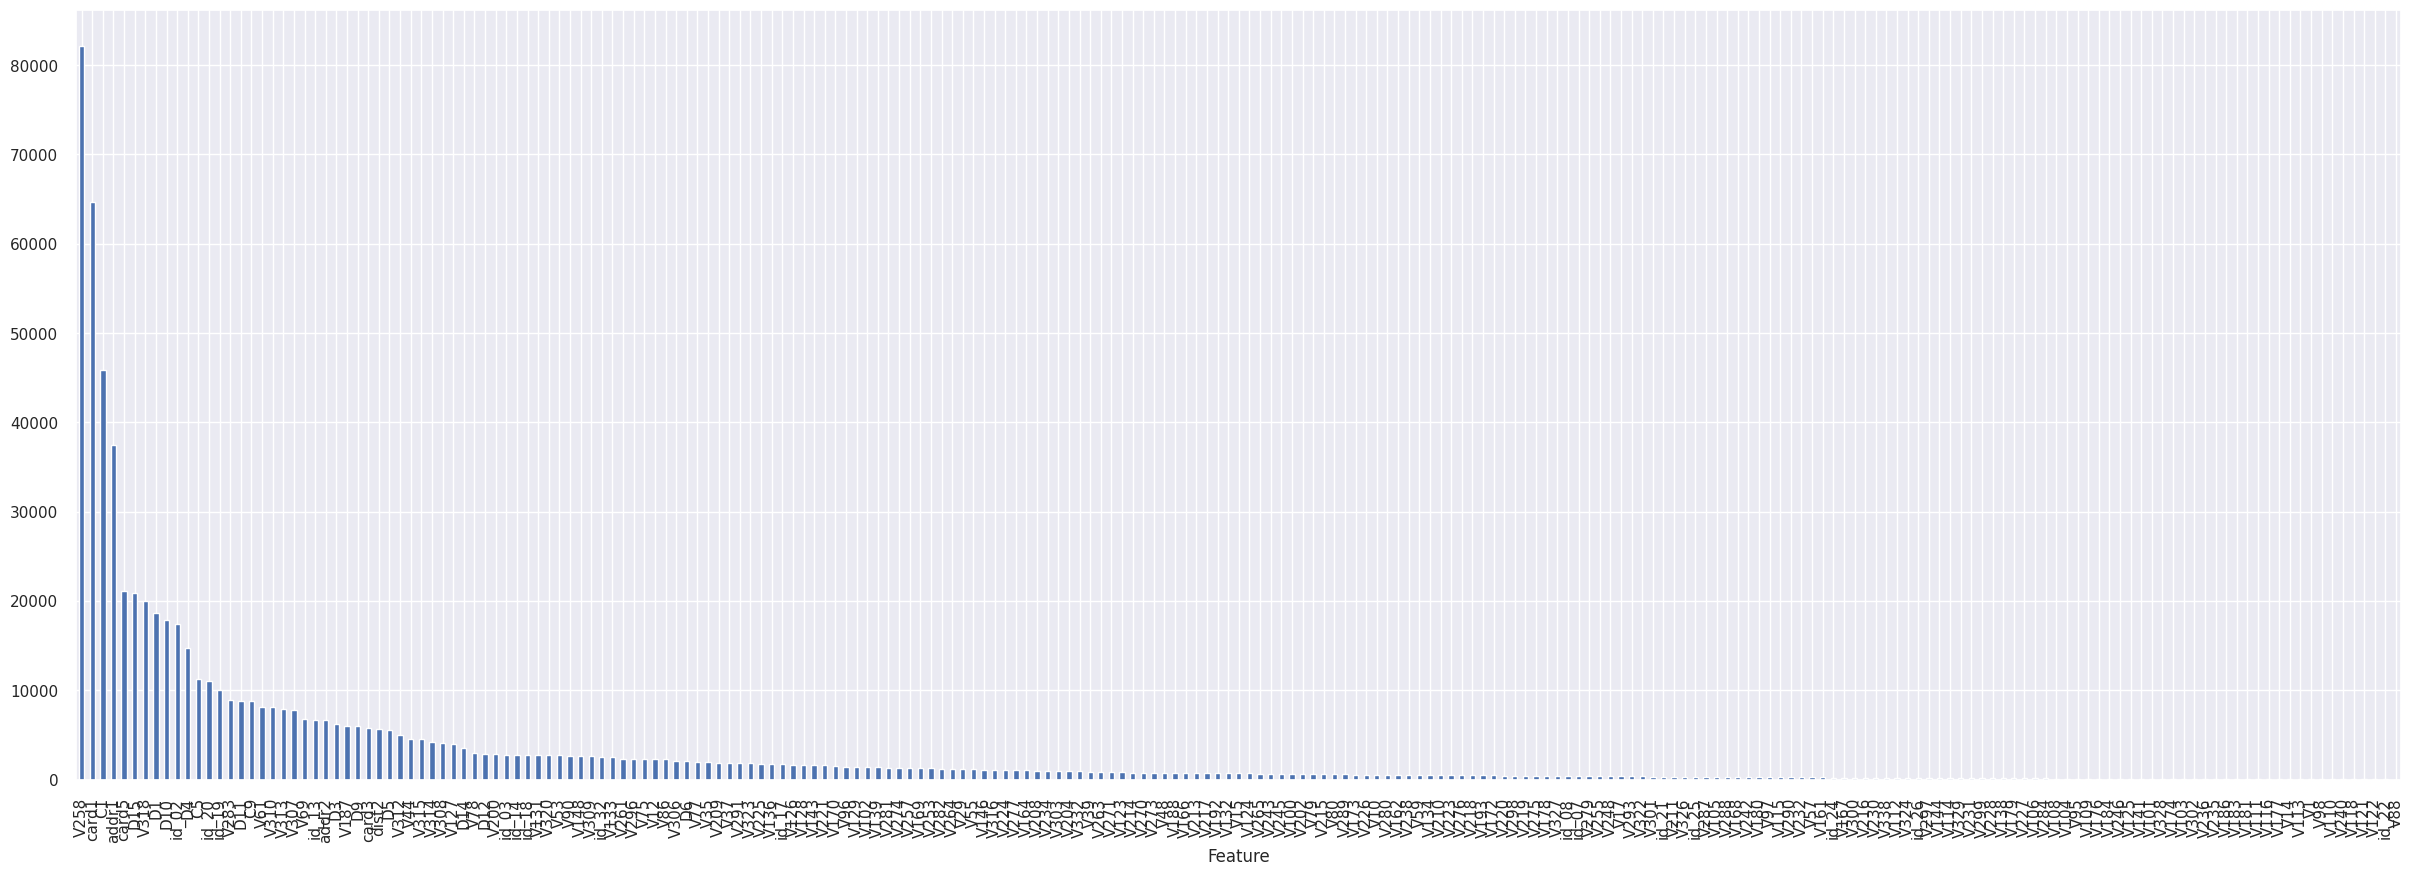

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
te_pred.shape, df_test_corw.shape

((172981, 1), (172981, 255))

In [ ]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': te_pred.data[:, 0]})
sub.head()

,TransactionID,isFraud
0,3404559,0.000178
1,3404560,0.005208
2,3404561,0.000352
3,3404562,0.002063
4,3404563,0.105571


In [ ]:
sub.to_csv('submission_baseline_13.csv', index=False)

In [ ]:
pd.DataFrame({
    'AutoML': ['Autogluon', 'LAMA'],
    'ROC-AUC на лидерборде': [0.87628, 0.86930],
})

,AutoML,ROC-AUC на лидерборде
0,Autogluon,0.87628
1,LAMA,0.86930


**Выводы:**

`Autogluon` и `LAMA` хорошо себя показали в решении такой сложной задачи. Передаваемый датасет был минимально предобработан. В нем были категориальные признаки, данные не были отмасштабированны. При этом качетсво, полученное на лидирборде, может почти сравниться с моим(( Мой лучший результат после всех эксперементов: 0.89452, поэтому все же, специальисты дата-саентисты лучше решают такие задачи. Таким образом, можно сделать вывод, несмотря на то, что AutoML показывают отличные результаты, все же, пока что эти инструменты не могут полностью заменить реальных специалистов в области DS.

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

Дополнительно я обучал модели в `Yandex Cloud`. Для этого в `Yandex Datasphere` я выбирал ВМ на `GPU`. Подбор гиперпараметров в `Google Colab` мог занимать несколько часов, а на `GPU` данная задача занимала считанные секунды. В итоге, из-за того, что `Google Colab` постоянно не справлялся с нагрузкой, пришлось полностью перейти в яндекс датасферу, поэтому все основные шаги, кроеме `EDA` и `AutoML`, были выполнены в `Yandex Cloud`. Подбор гиперпараметров на `GPU` для `CatBoost`, как видно на фото, занял всего 5 минут, тогда как в `Google Colab` этот процесс на `CPU` занимал около часа (в 12 раз быстрее!). Так обучение на `GPU` процесс дорогостоящий, я перешел на стандартный `CPU 4 ядра RAM 32GB`. При таких настройках в `Google Colab` `DBSCAN` работал ~20 минут, а в `Yandex Datasphere` всего лишь 5 минут (в 4 раза быстрее).

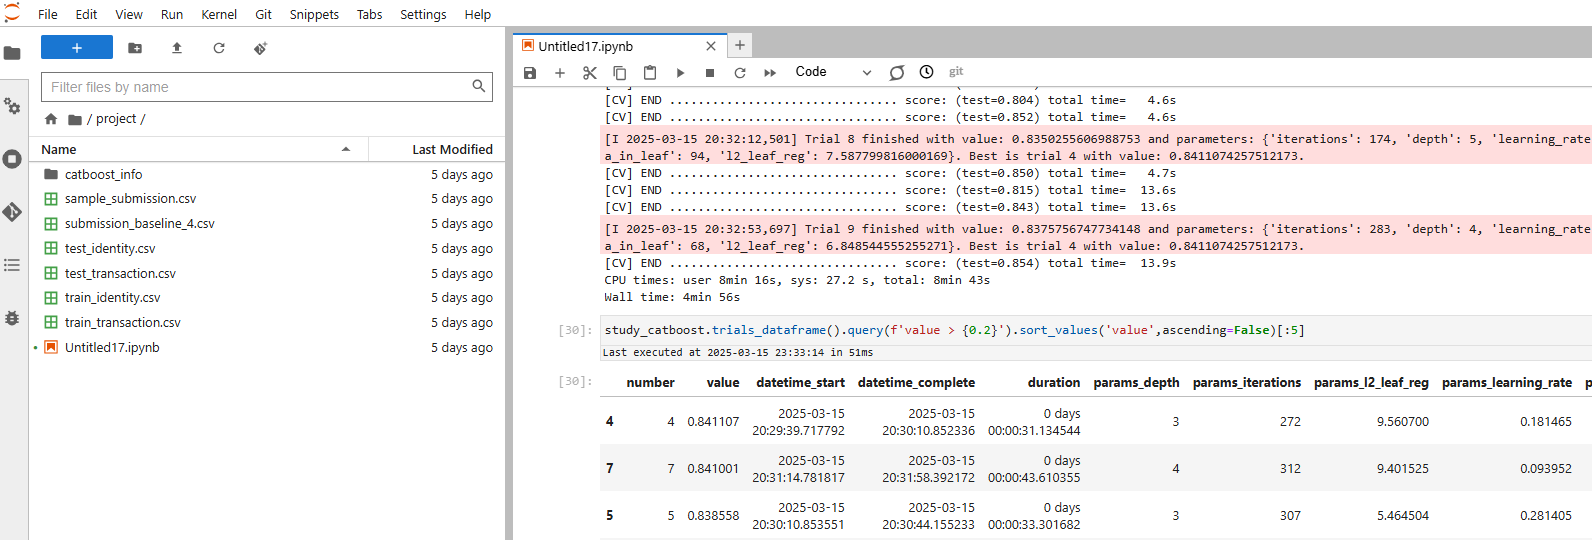

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

Я закончил соревнование на 34 месте с бейзлайном LightGBM из ноутбука с функцией оптимизации типов данных признаков до мягкого дедлайна. При этом все дальнейшие действия, направленные на улучшение результатов не привели к успеху(( Наилучший результат был получен после подбора гиперпараметров для LightGBM (roc_auc = 0.89452 на лидерборде). Думаю, что если увеличить число trials в optuna, можно достигнуть чуть лучшего качество. Также имеет смысл еще глубже изучить данные, и лучше подготовить данные перед обучением моделей. Бонусные баллы давали за попадания в топы, куда я не попал, но я очень старался)))


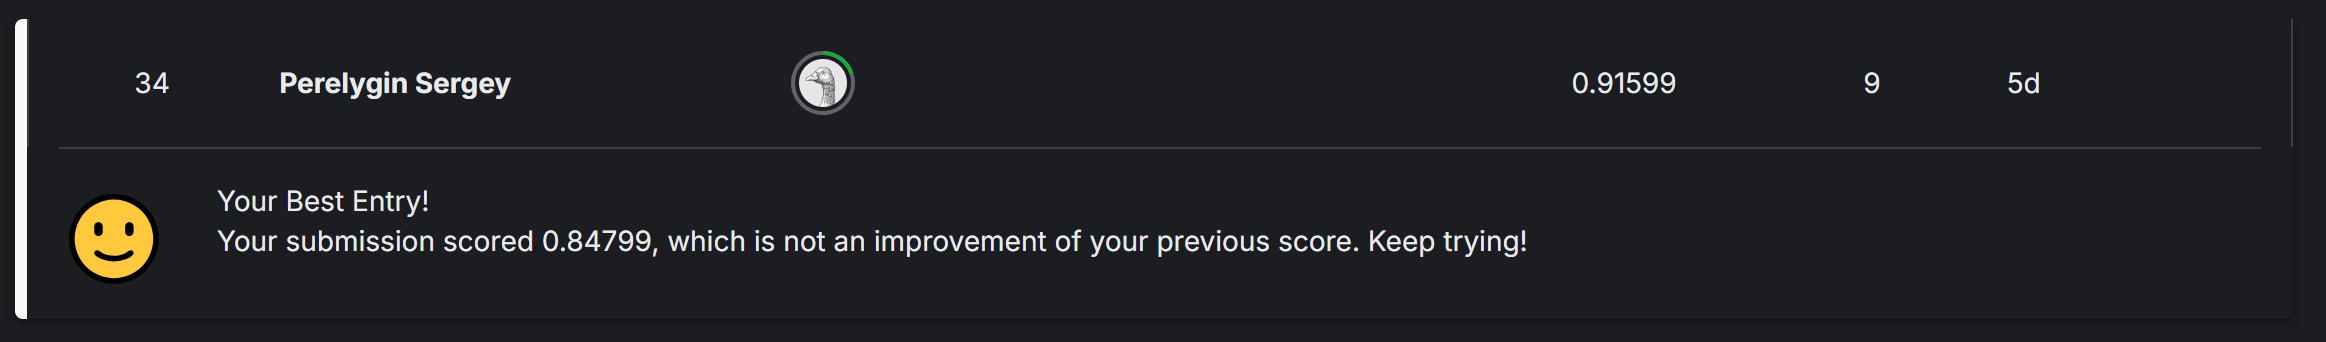

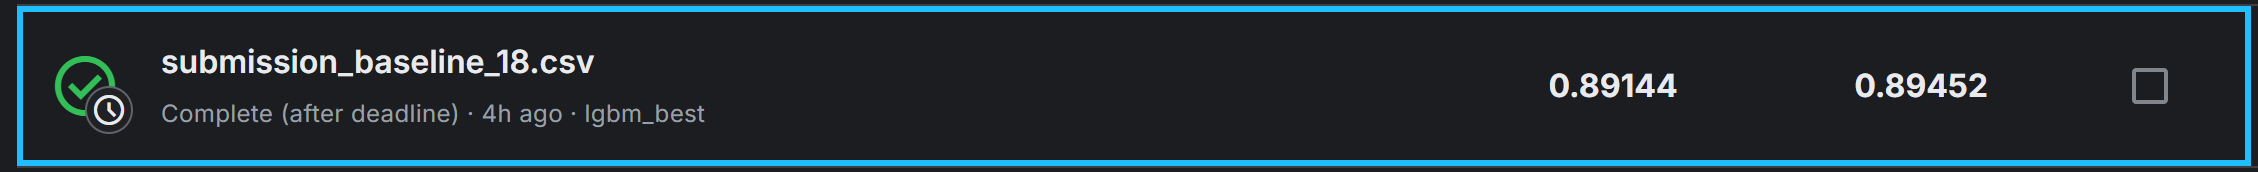

### **Спасибо за проверку всех домашек по ML, Виктор!**